In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:

mpl.rcParams['figure.dpi'] = 1000

In [3]:
THRESHOLD_COUNT = 100
COLOR_SPACE = cv2.COLOR_BGR2YUV
THRESHOLD = [0, 0, 0]
MODEL = [[0, 0], [0, 0], [0, 0]]

In [4]:
skin_data = pd.read_csv("Skin_NonSkin.txt", names=["r", "g", "b", "skin"], sep="\t")

In [5]:
skin_data.head()

r   g    b  skin
0  74  85  123     1
1  73  84  122     1
2  72  83  121     1
3  70  81  119     1
4  70  81  119     1

In [6]:
rgb_skin = skin_data.iloc[:,:-1].values

rgb_skin = rgb_skin.reshape((1, rgb_skin.shape[0], 3))
rgb_skin[:, :5]

array([[[ 74,  85, 123],
        [ 73,  84, 122],
        [ 72,  83, 121],
        [ 70,  81, 119],
        [ 70,  81, 119]]], dtype=int64)

In [7]:
hsv_skin = cv2.cvtColor(np.uint8(rgb_skin), COLOR_SPACE)
hsv_skin= hsv_skin.reshape((hsv_skin.shape[1], 3))
hsv_skin[:5]

array([[102, 142, 141],
       [101, 142, 141],
       [100, 142, 141],
       [ 98, 142, 141],
       [ 98, 142, 141]], dtype=uint8)

In [8]:
rgb2_skin = hsv_skin.reshape((1, hsv_skin.shape[0], 3))

rgb2_skin = cv2.cvtColor(np.uint8(rgb2_skin), cv2.COLOR_HSV2RGB)
rgb2_skin= rgb2_skin.reshape((rgb2_skin.shape[1], 3))
rgb2_skin[:5]

array([[ 62, 109, 141],
       [ 62, 112, 141],
       [ 62, 114, 141],
       [ 62, 120, 141],
       [ 62, 120, 141]], dtype=uint8)

In [9]:
skin_data["color_0"] = hsv_skin[:, 0]
skin_data["color_1"] = hsv_skin[:, 1]
skin_data["color_2"] = hsv_skin[:, 2]

skin_data.head()

r   g    b  skin  color_0  color_1  color_2
0  74  85  123     1      102      142      141
1  73  84  122     1      101      142      141
2  72  83  121     1      100      142      141
3  70  81  119     1       98      142      141
4  70  81  119     1       98      142      141

In [10]:
means  = skin_data.loc[skin_data['skin'] == 1].mean()
hsv_skin_model_mean = [
    means["color_0"],
    means["color_1"],
    means["color_2"]
]

stds  = skin_data.loc[skin_data['skin'] == 1].std()
hsv_skin_model_std = [
    stds["color_0"],
    stds["color_1"],
    stds["color_2"]
]
hsv_skin_model_mean


[166.90121709038715, 146.01930828368626, 154.02795965315875]

In [11]:
skin_data["color_0_dist"] = np.abs((skin_data["color_0"] - hsv_skin_model_mean[0]) /\
                             hsv_skin_model_std[0])

skin_data["color_1_dist"] = np.abs((skin_data["color_1"] - hsv_skin_model_mean[1]) /\
                             hsv_skin_model_std[1])

skin_data["color_2_dist"] = np.abs((skin_data["color_2"] - hsv_skin_model_mean[2]) /\
                             hsv_skin_model_std[2])

skin_data.head()

r   g    b  skin  color_0  color_1  color_2  color_0_dist  color_1_dist  \
0  74  85  123     1      102      142      141      1.876372      1.055977   
1  73  84  122     1      101      142      141      1.905283      1.055977   
2  72  83  121     1      100      142      141      1.934194      1.055977   
3  70  81  119     1       98      142      141      1.992017      1.055977   
4  70  81  119     1       98      142      141      1.992017      1.055977   

   color_2_dist  
0      1.352357  
1      1.352357  
2      1.352357  
3      1.352357  
4      1.352357

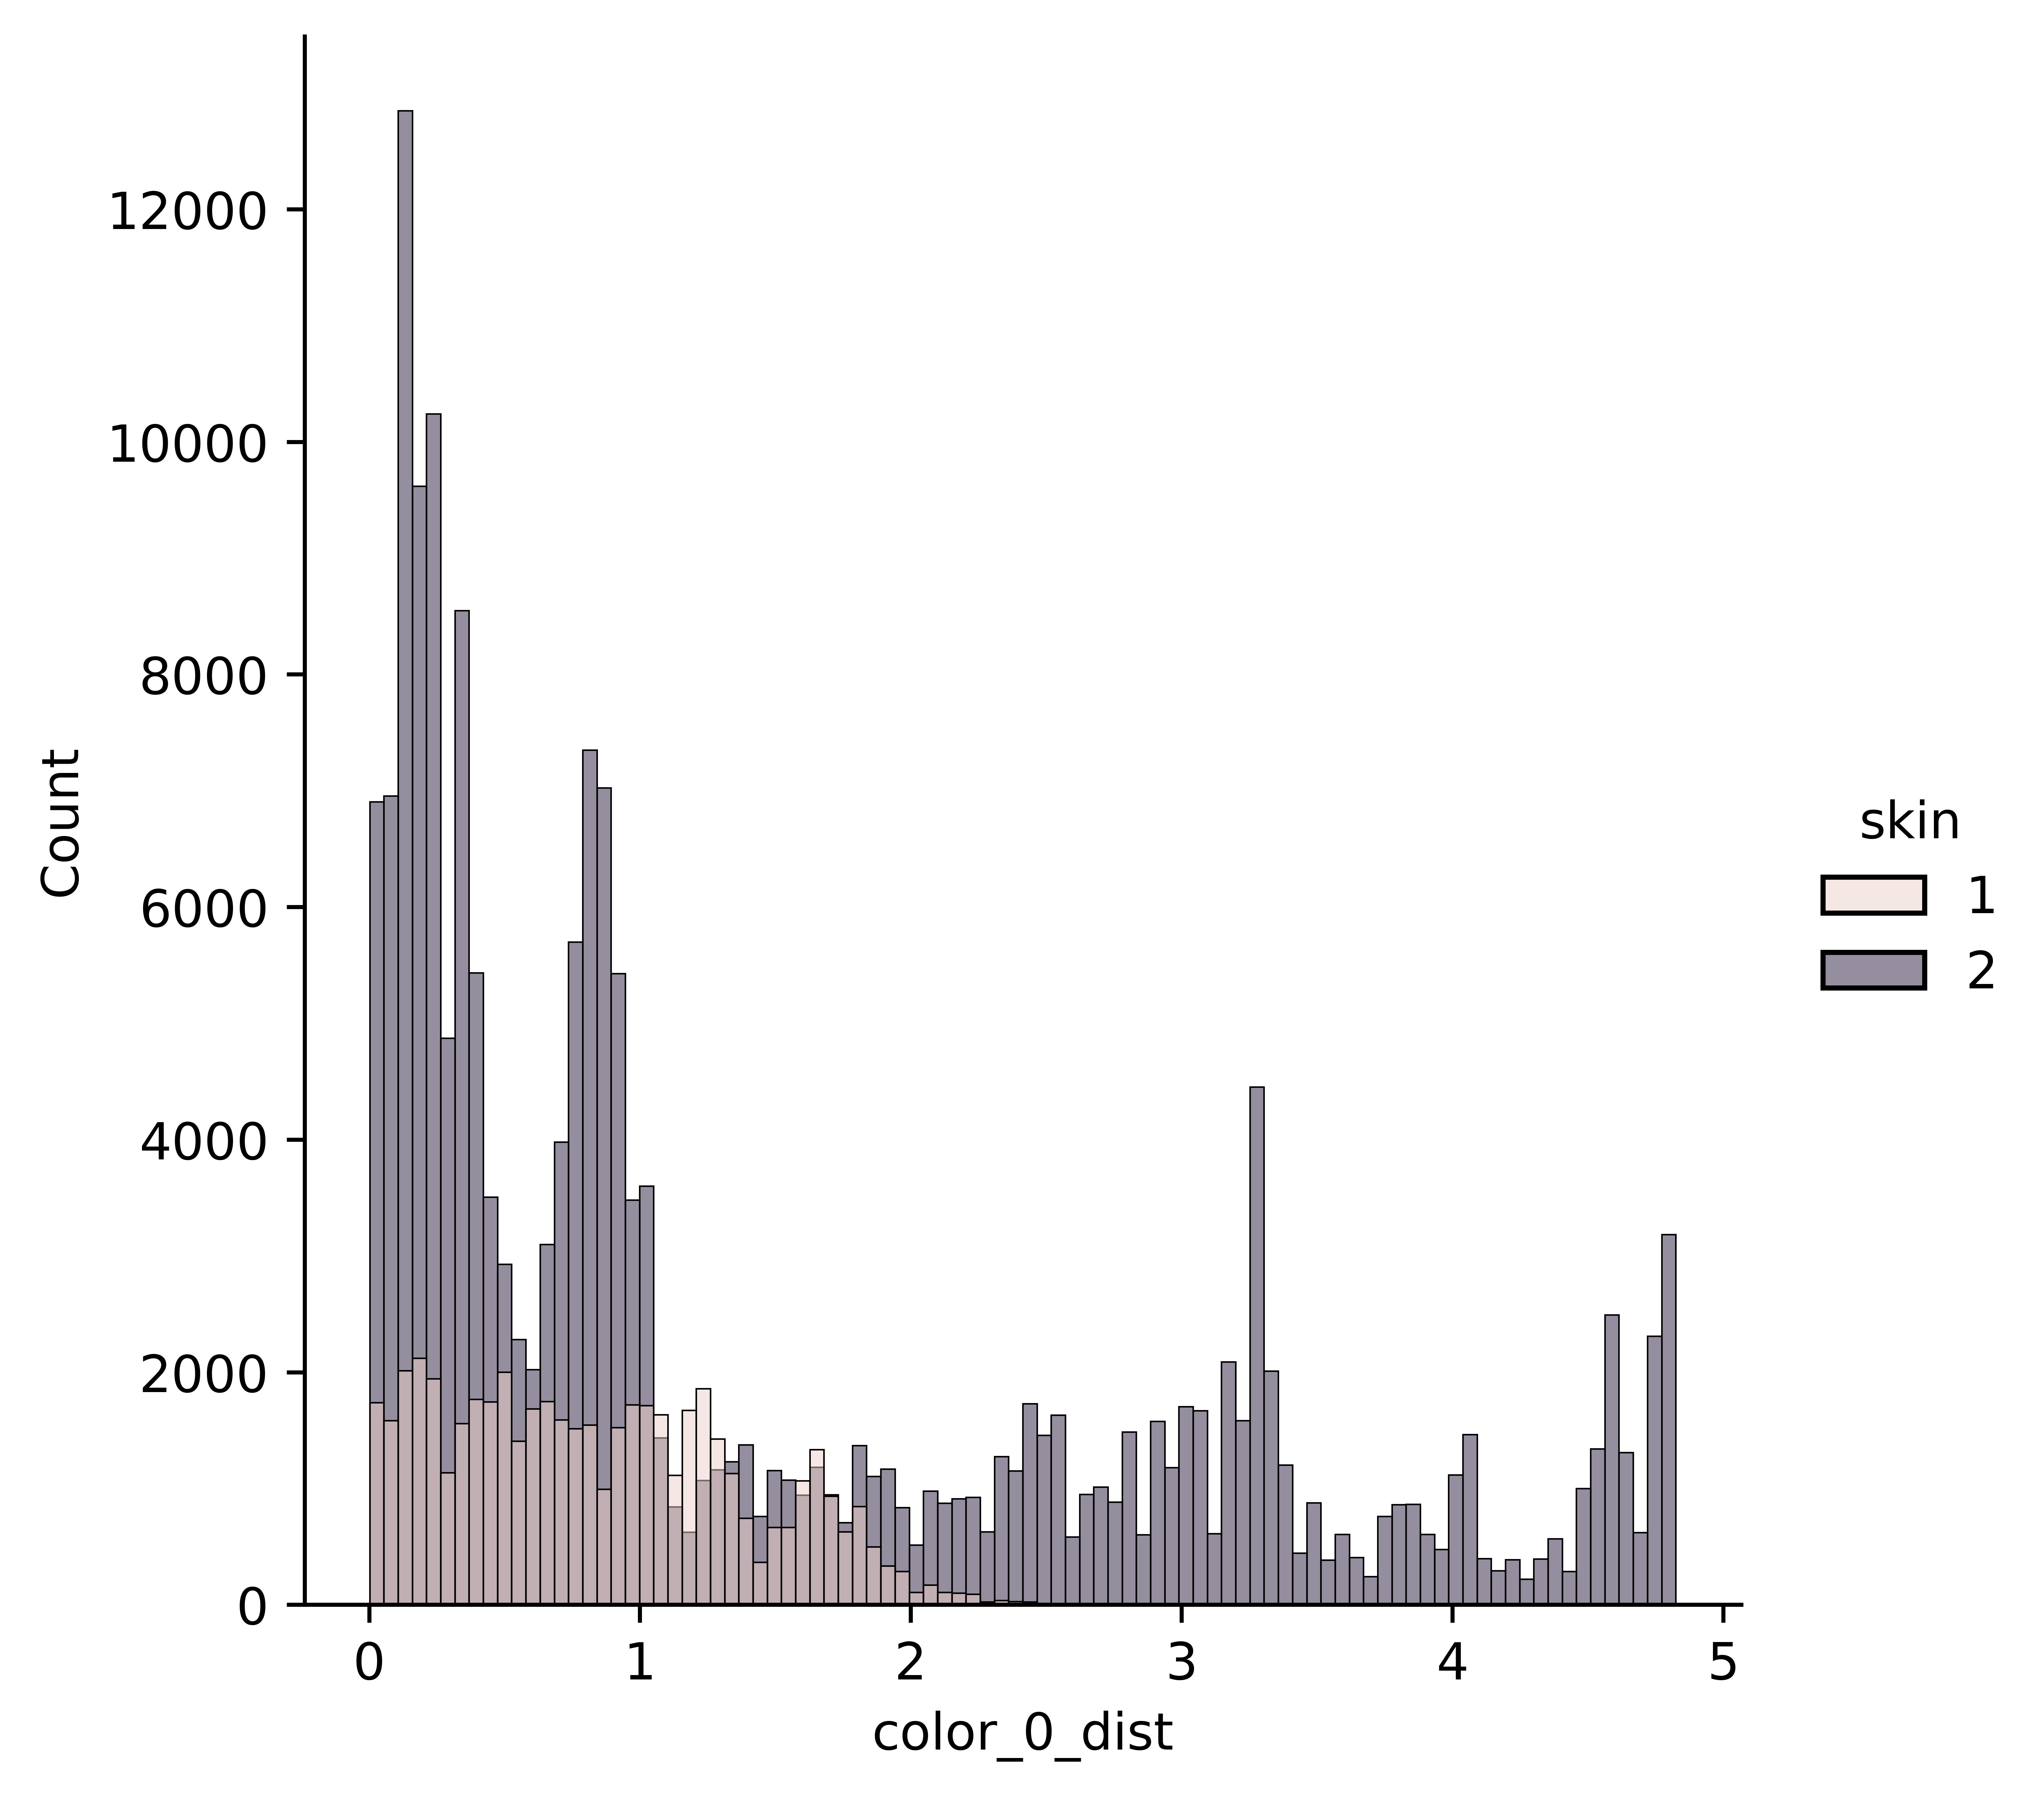

In [12]:
sns.displot(data=skin_data, x="color_0_dist", hue="skin")

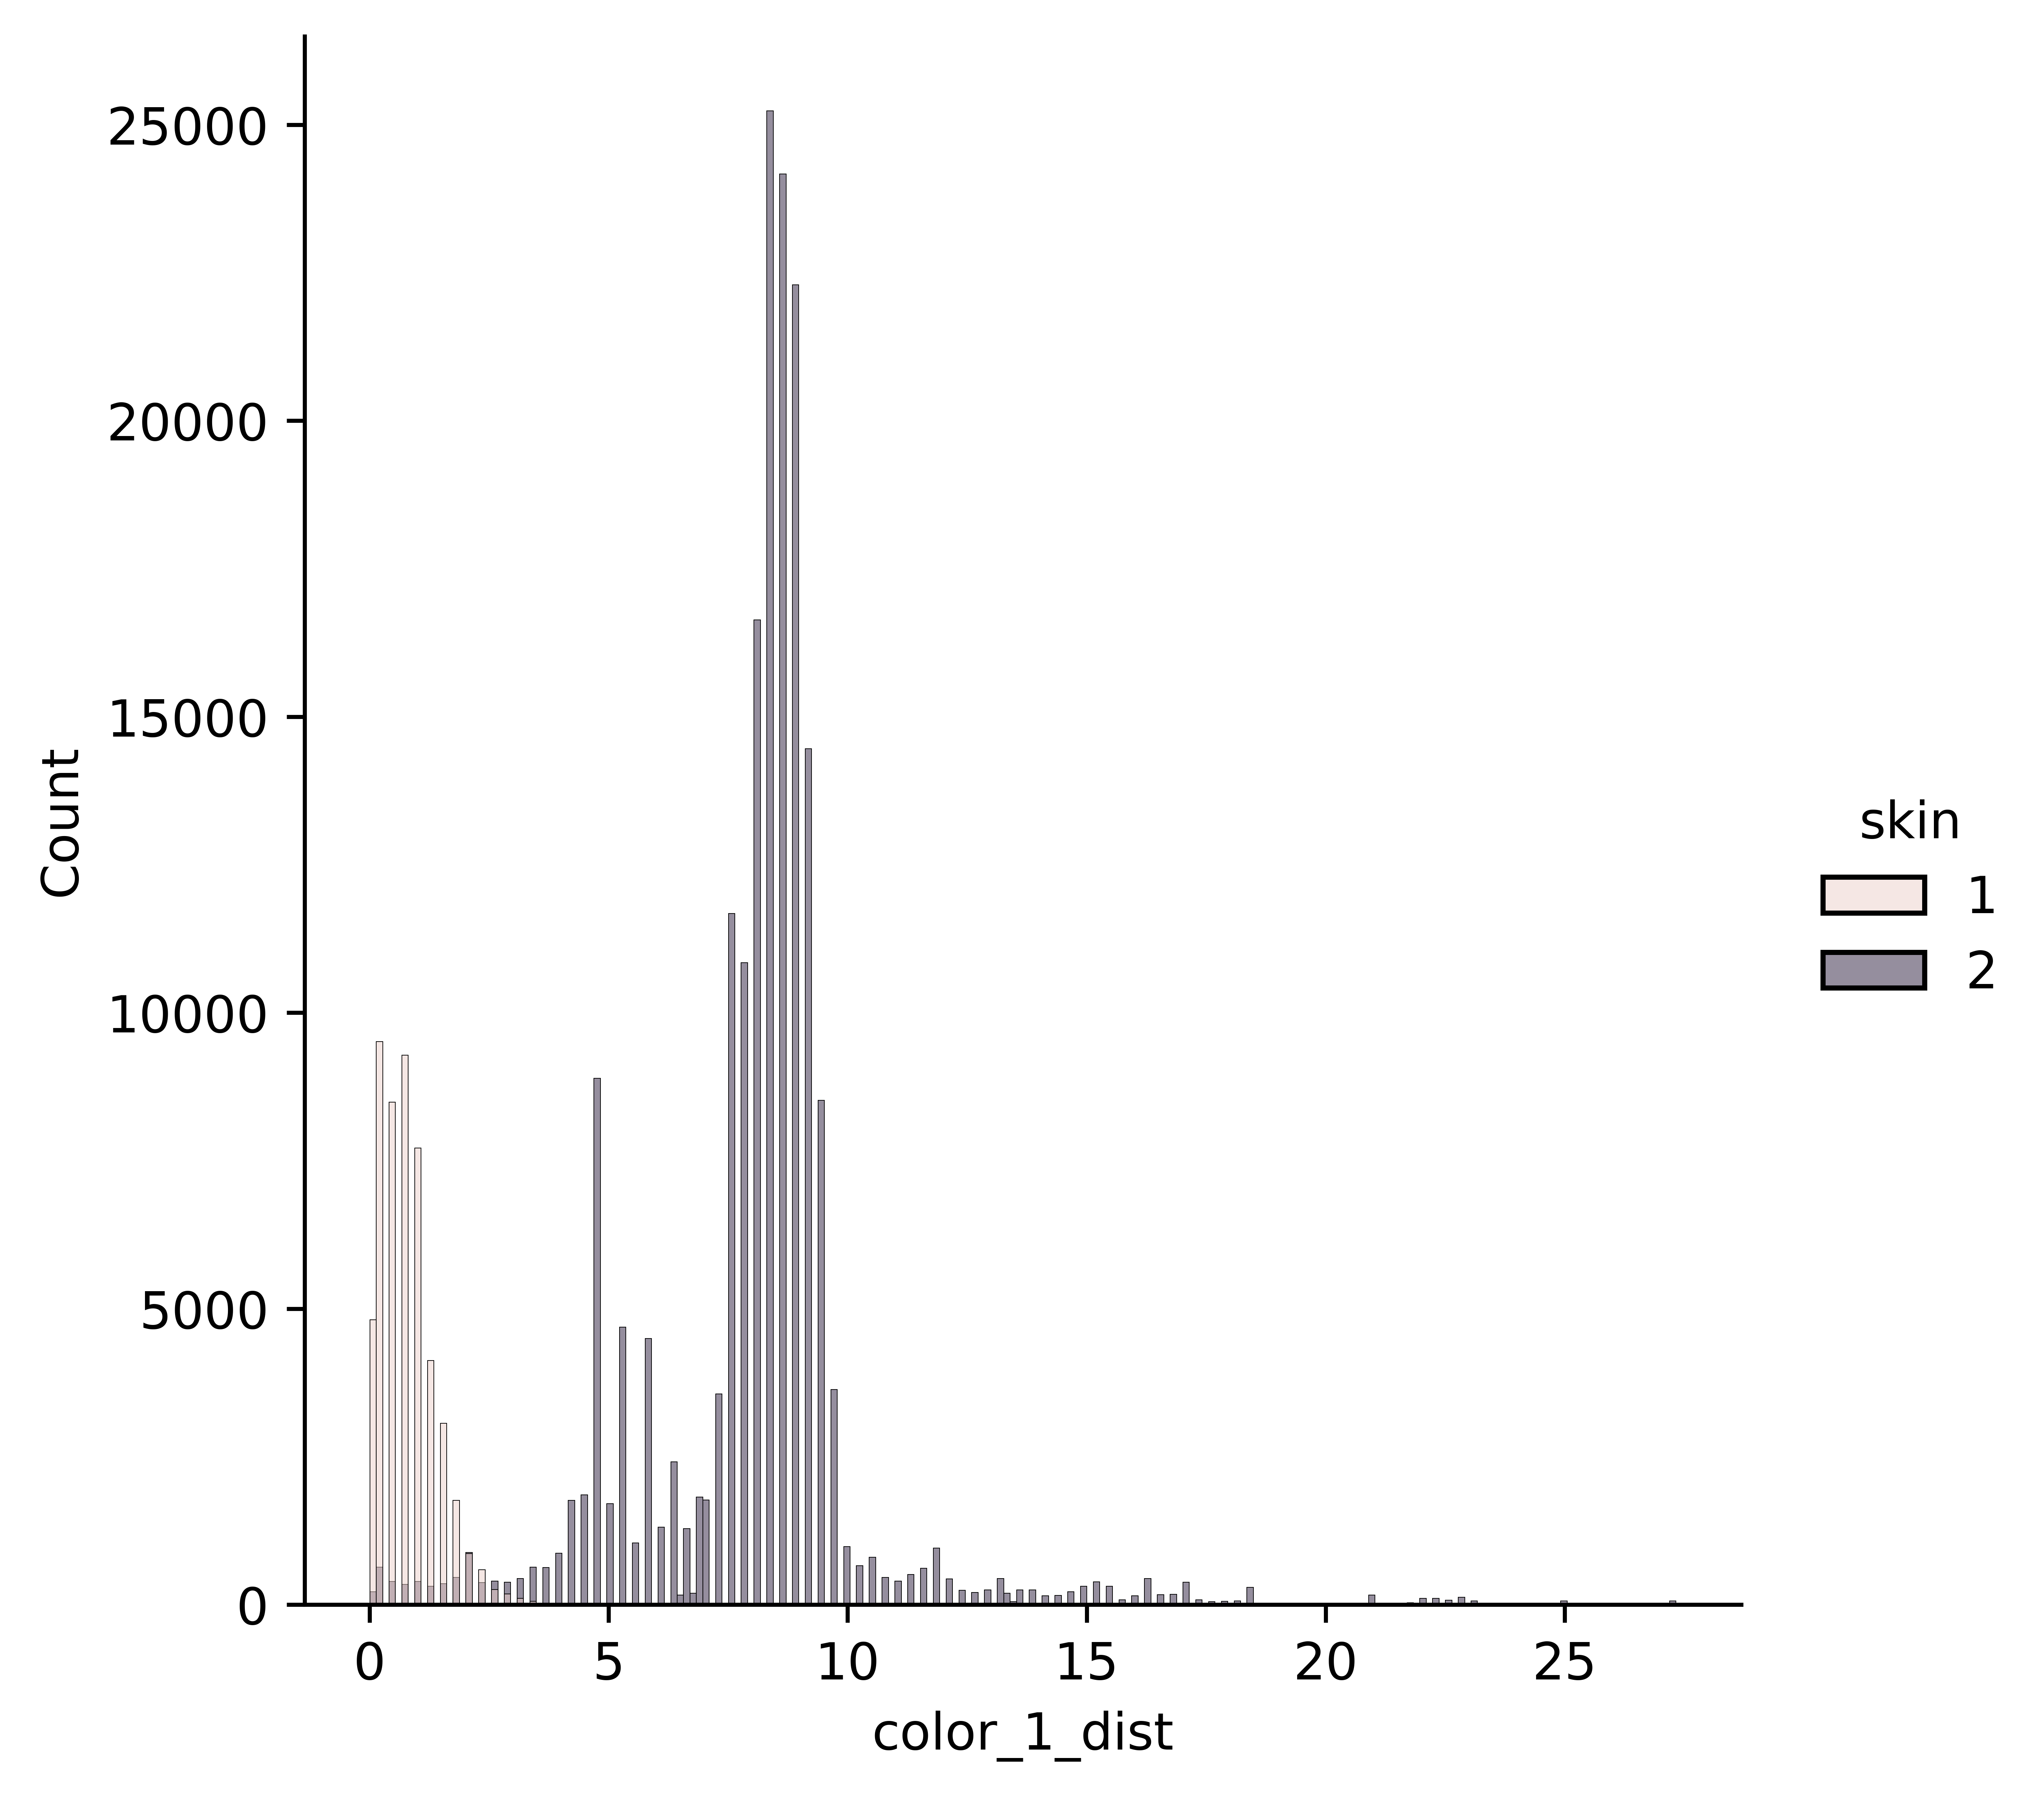

In [13]:
sns.displot(data=skin_data, x="color_1_dist", hue="skin")

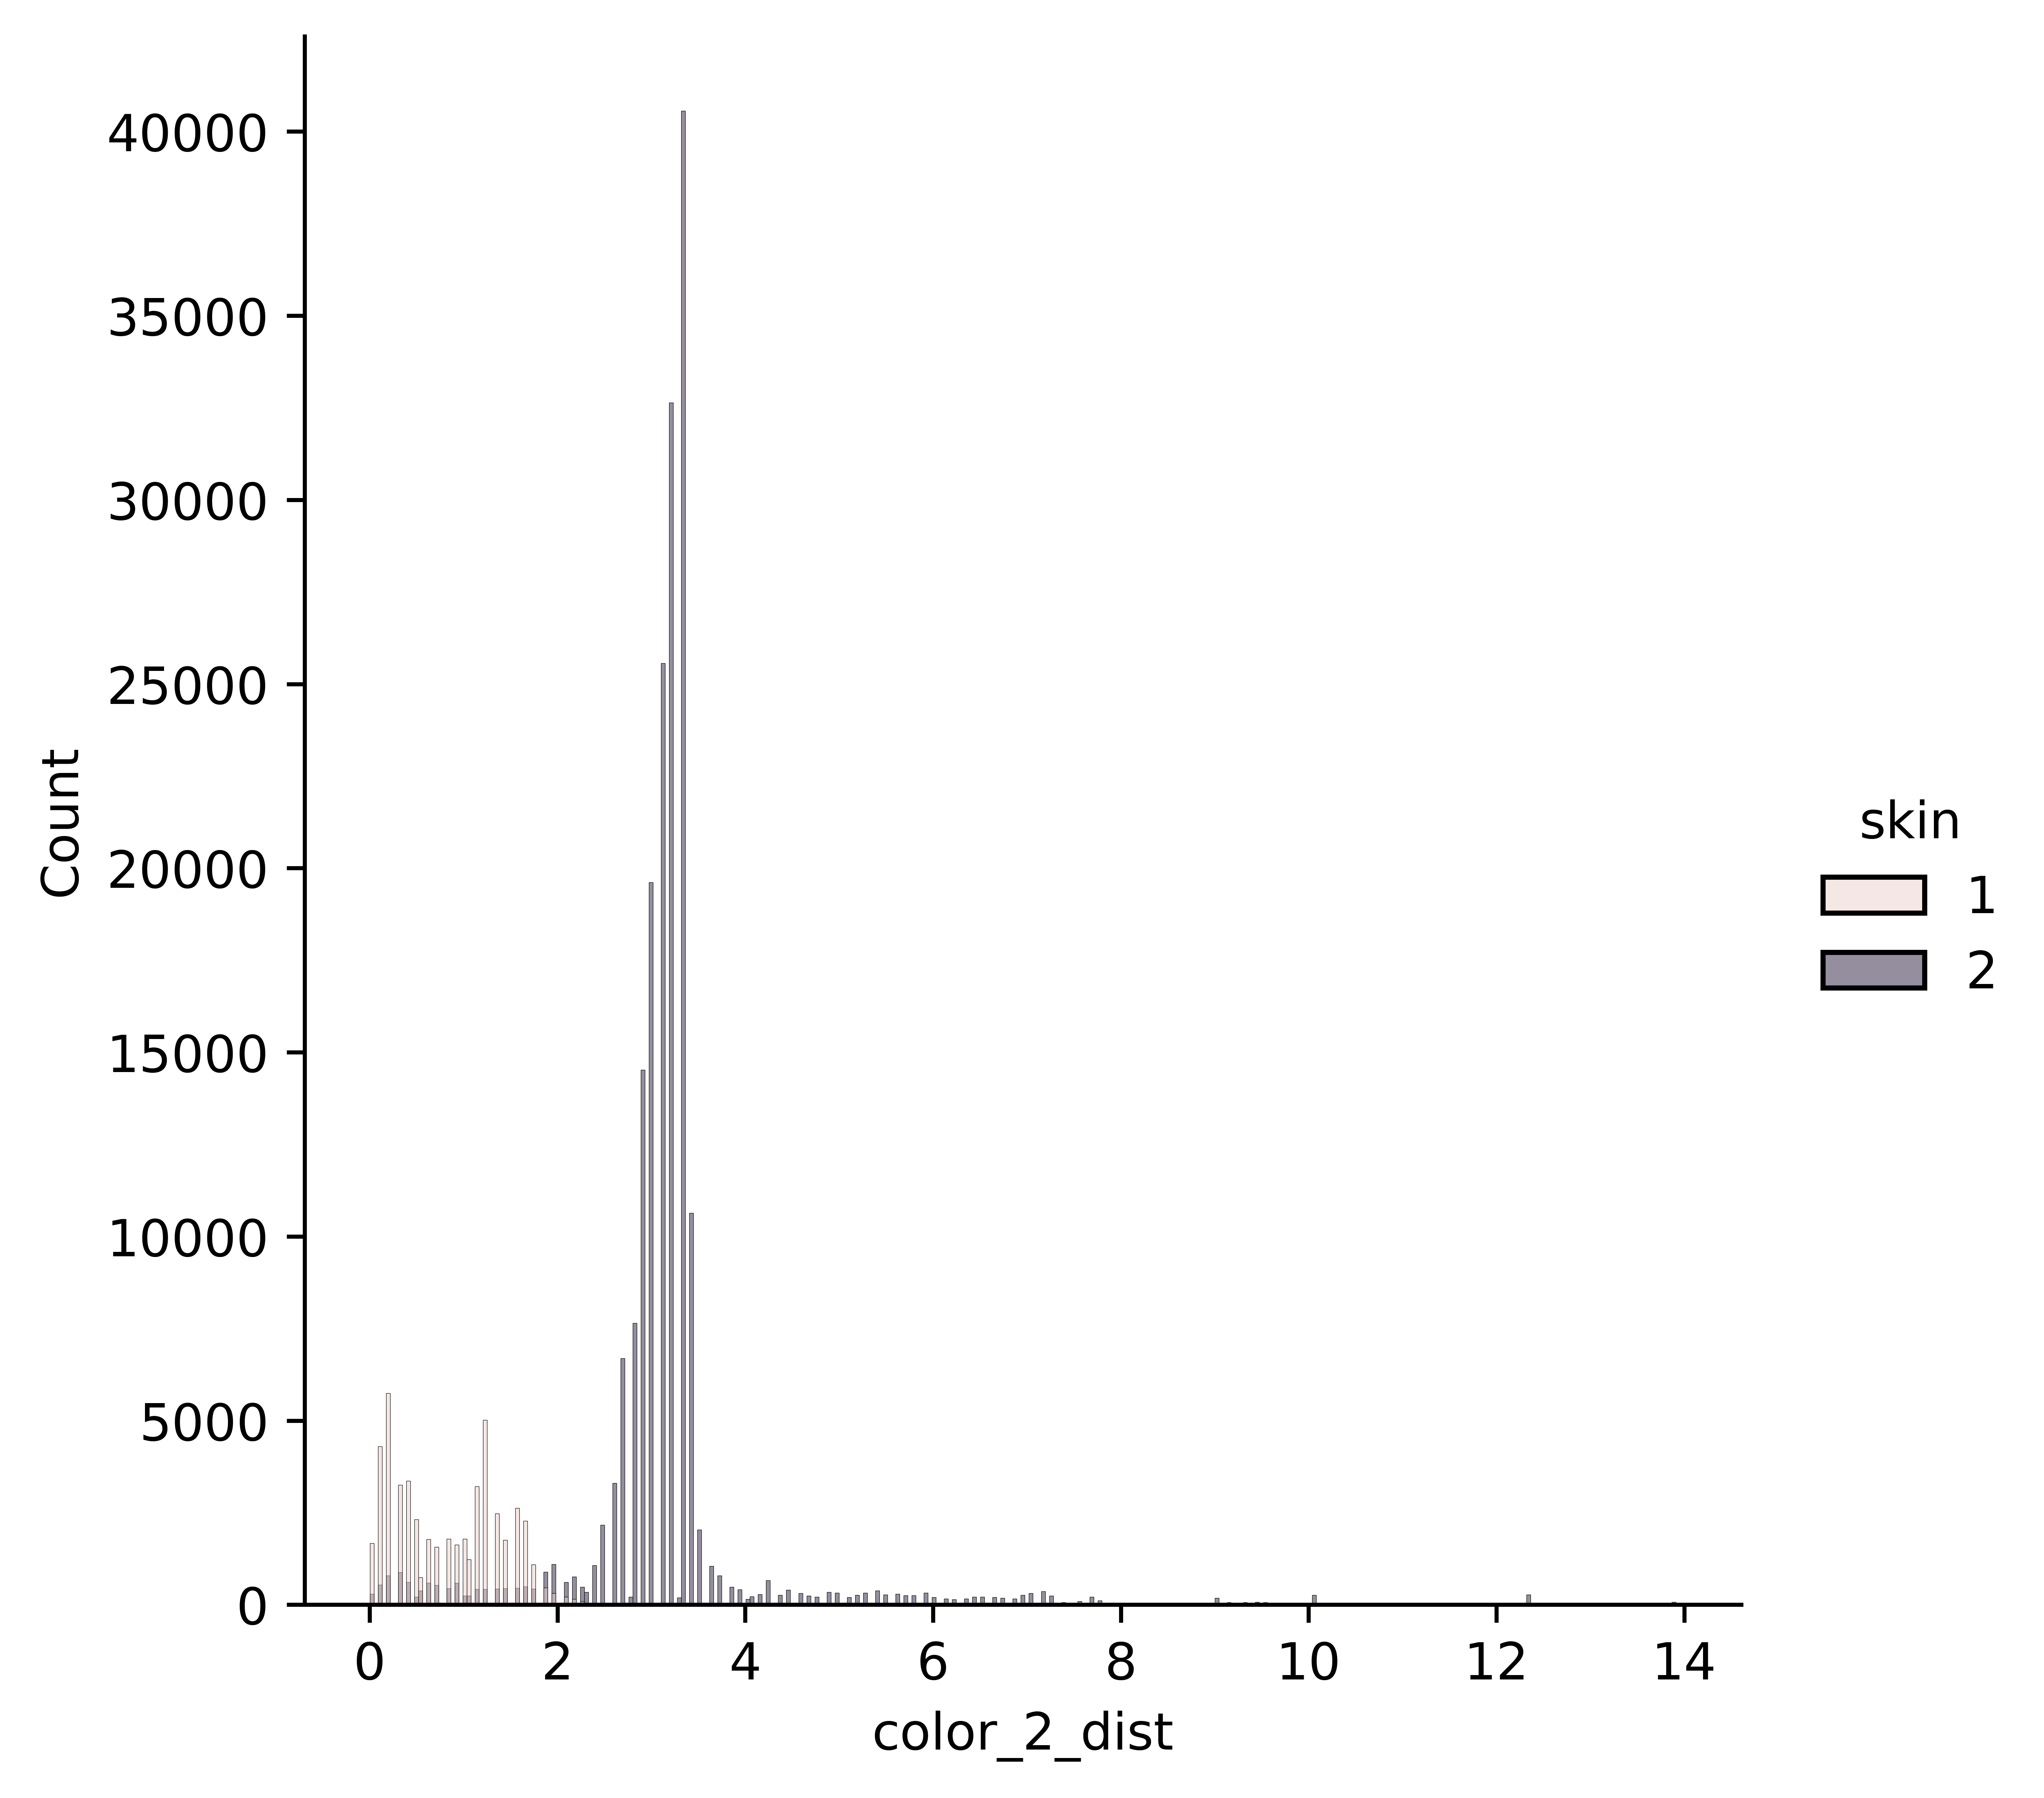

In [14]:
sns.displot(data=skin_data, x="color_2_dist", hue="skin")

In [15]:
list(range(3))

[0, 1, 2]

In [16]:
true_positives = [0,0,0]
false_positives = [0,0,0]
true_negatives = [0,0,0]
false_negatives = [0,0,0]
m_thresh = [0,0,0]
thresholds = [0,0,0]

In [17]:
for color_num in range(3):
    color_channel = "color_%d"%color_num
    true_positives[color_num] = np.zeros(THRESHOLD_COUNT)
    false_positives[color_num] = np.zeros(THRESHOLD_COUNT)
    true_negatives[color_num] = np.zeros(THRESHOLD_COUNT)
    false_negatives[color_num] = np.zeros(THRESHOLD_COUNT)


    color_data = skin_data.loc[:, ['skin', color_channel + '_dist']] 
    color_data["skin"] = color_data["skin"] == 1
    color_data.head()
    
    thresholds[color_num] = np.linspace(min(skin_data[color_channel + "_dist"]),
                                        max(skin_data[color_channel + "_dist"]),
                                        THRESHOLD_COUNT)
    total = color_data.count()[0]
    positives = color_data.loc[color_data["skin"]].count()[0]

    for threshold_index in range(len(thresholds[color_num])):
    # threshold_index = 0
#         print(color_channel + "_dist")
#         print(thresholds[color_num][threshold_index])
#         print(color_data[color_channel + "_dist"])
    
        color_data["prediction"] = color_data[color_channel + "_dist"] <= thresholds[color_num][threshold_index]
        true_positives[color_num][threshold_index] = color_data.loc[(color_data["skin"] == color_data["prediction"]) &  color_data["prediction"]].count()[0]
        true_negatives[color_num][threshold_index] = color_data.loc[(color_data["skin"] == color_data["prediction"]) &  ~color_data["prediction"]].count()[0]
        false_positives[color_num][threshold_index] = color_data.loc[(color_data["skin"] != color_data["prediction"]) &  color_data["prediction"]].count()[0]
        false_negatives[color_num][threshold_index] = color_data.loc[(color_data["skin"] != color_data["prediction"]) &  ~color_data["prediction"]].count()[0]
    # color_data.head()

    m_thresh[color_num] = (1.0 - false_positives[color_num]/(total - positives)) + ((true_positives[color_num]/positives) * 10)

    THRESHOLD[color_num] = min(thresholds[color_num][np.argmax(m_thresh[color_num])], thresholds[color_num][-1])
    MODEL[color_num] = [hsv_skin_model_mean[color_num], hsv_skin_model_std[color_num]]

<AxesSubplot:>

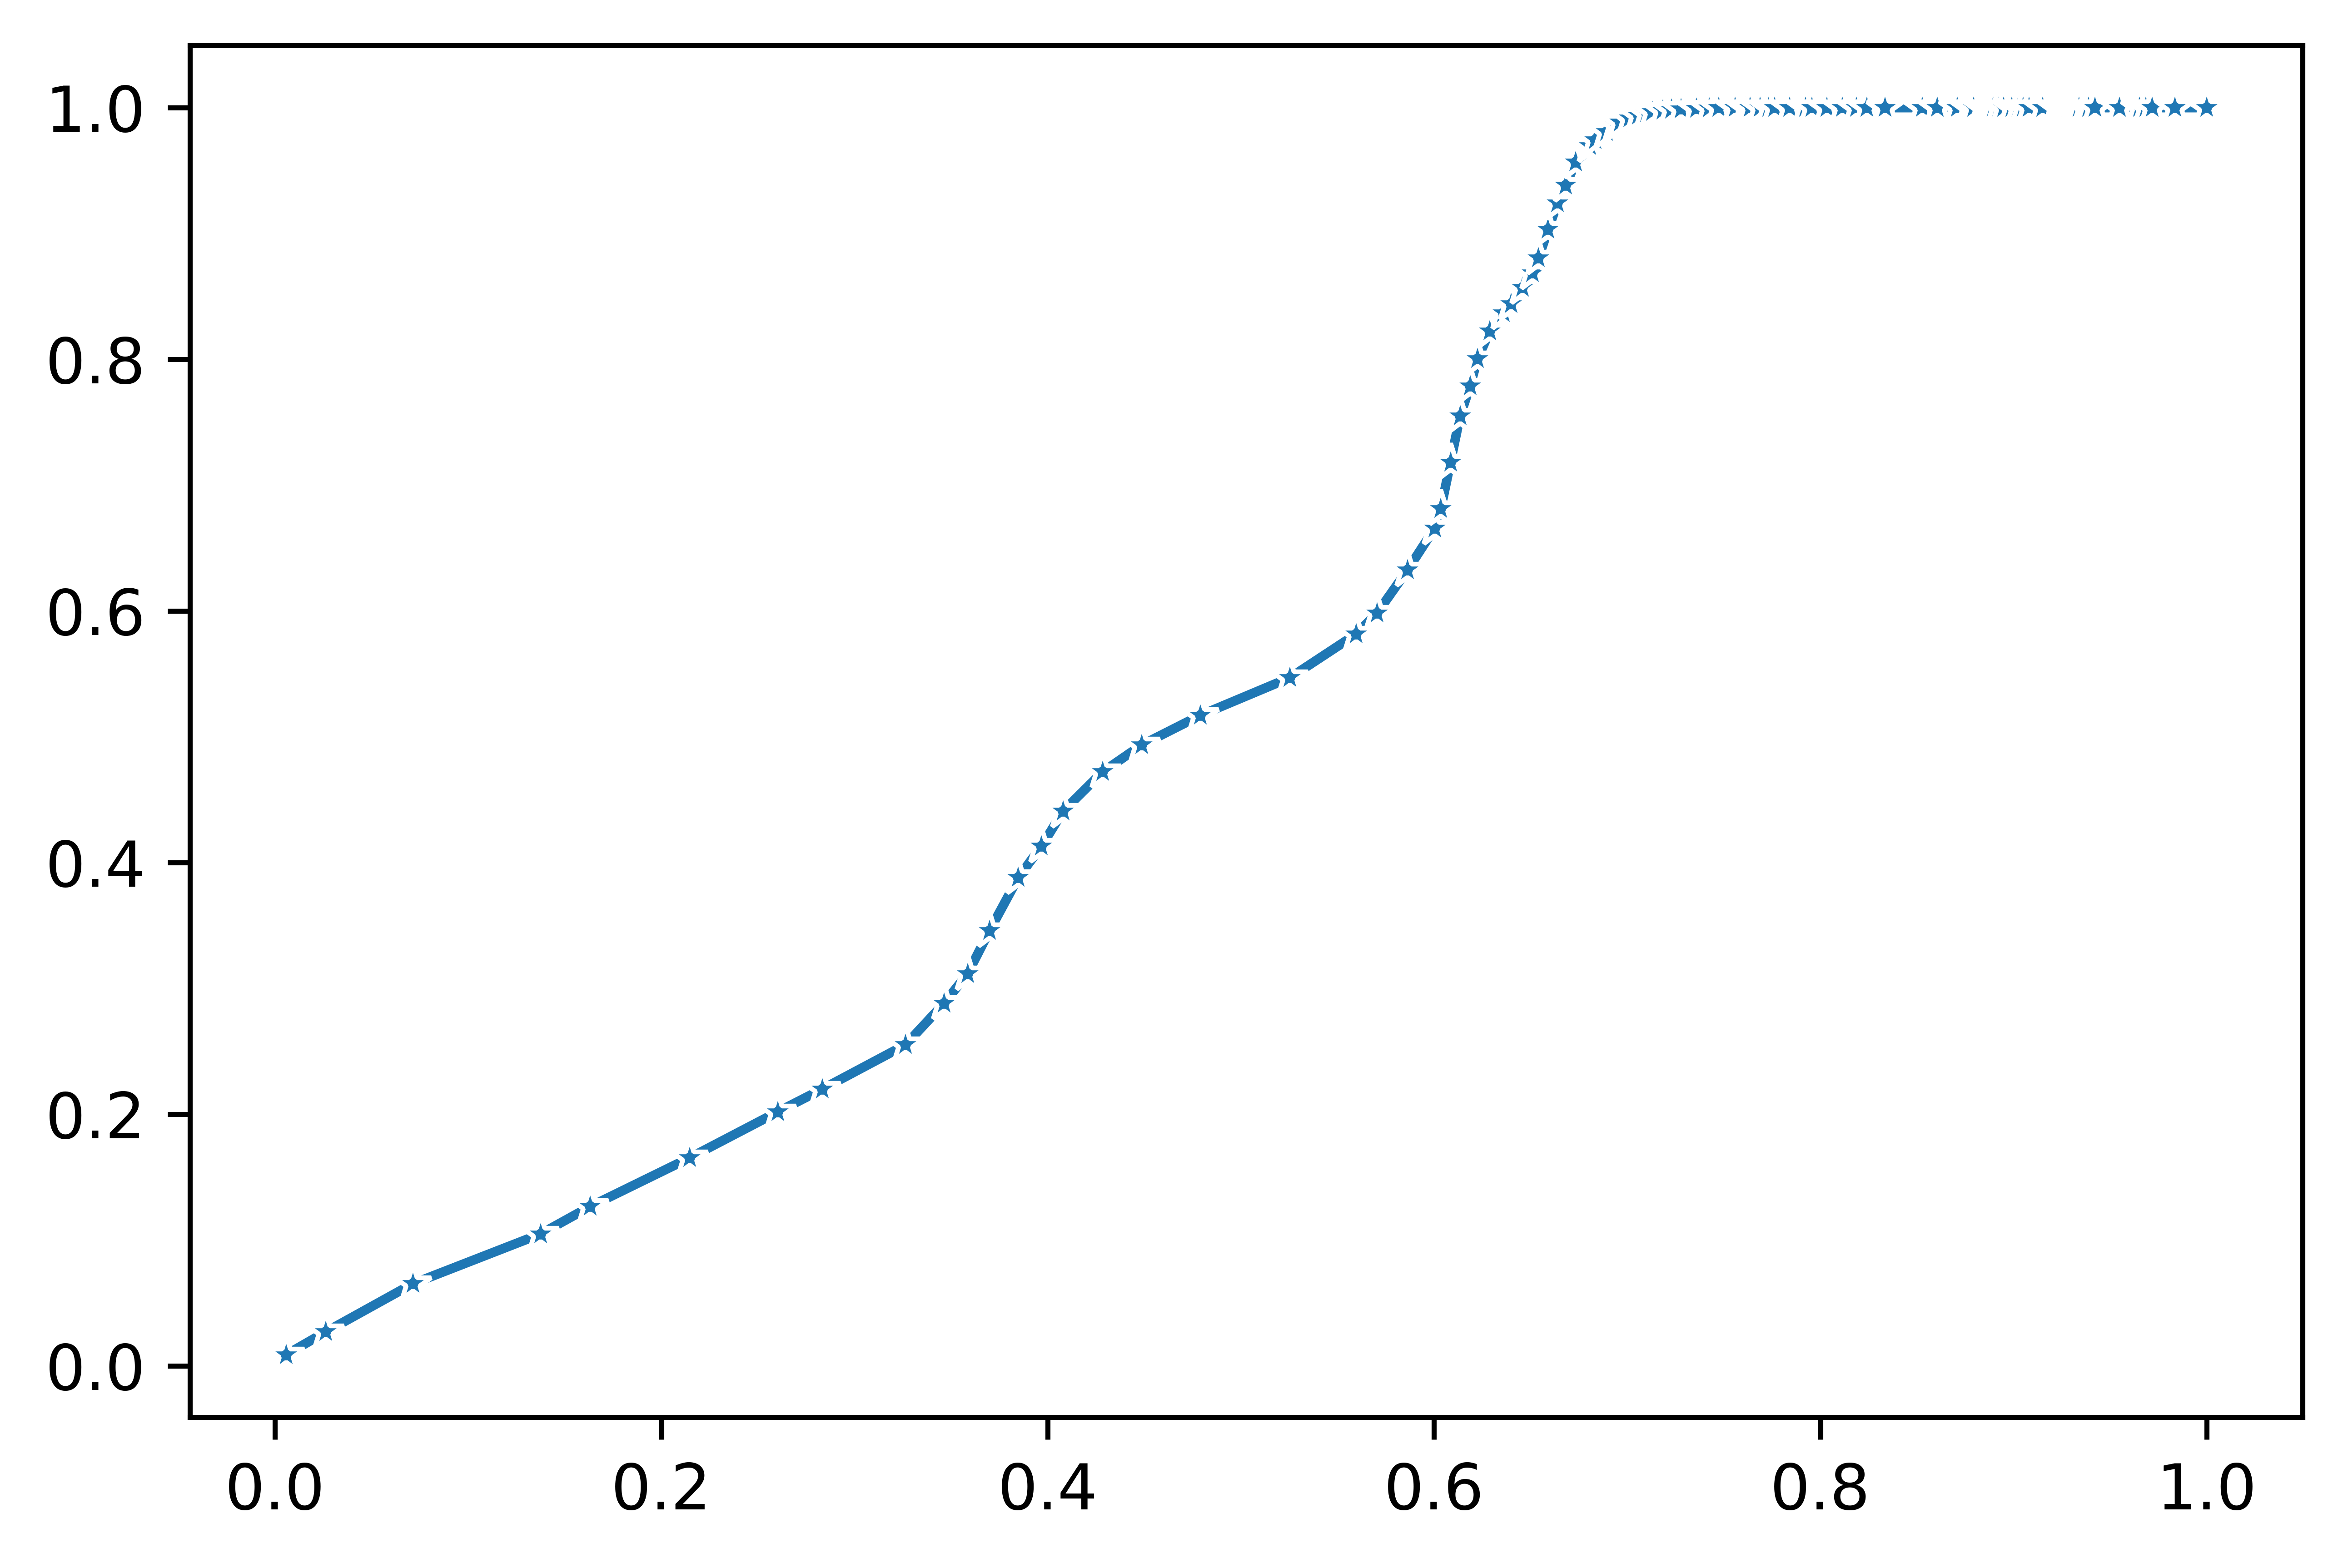

In [18]:
sns.lineplot(x=false_positives[0]/(total - positives), y=true_positives[0]/positives, marker='*')

<AxesSubplot:>

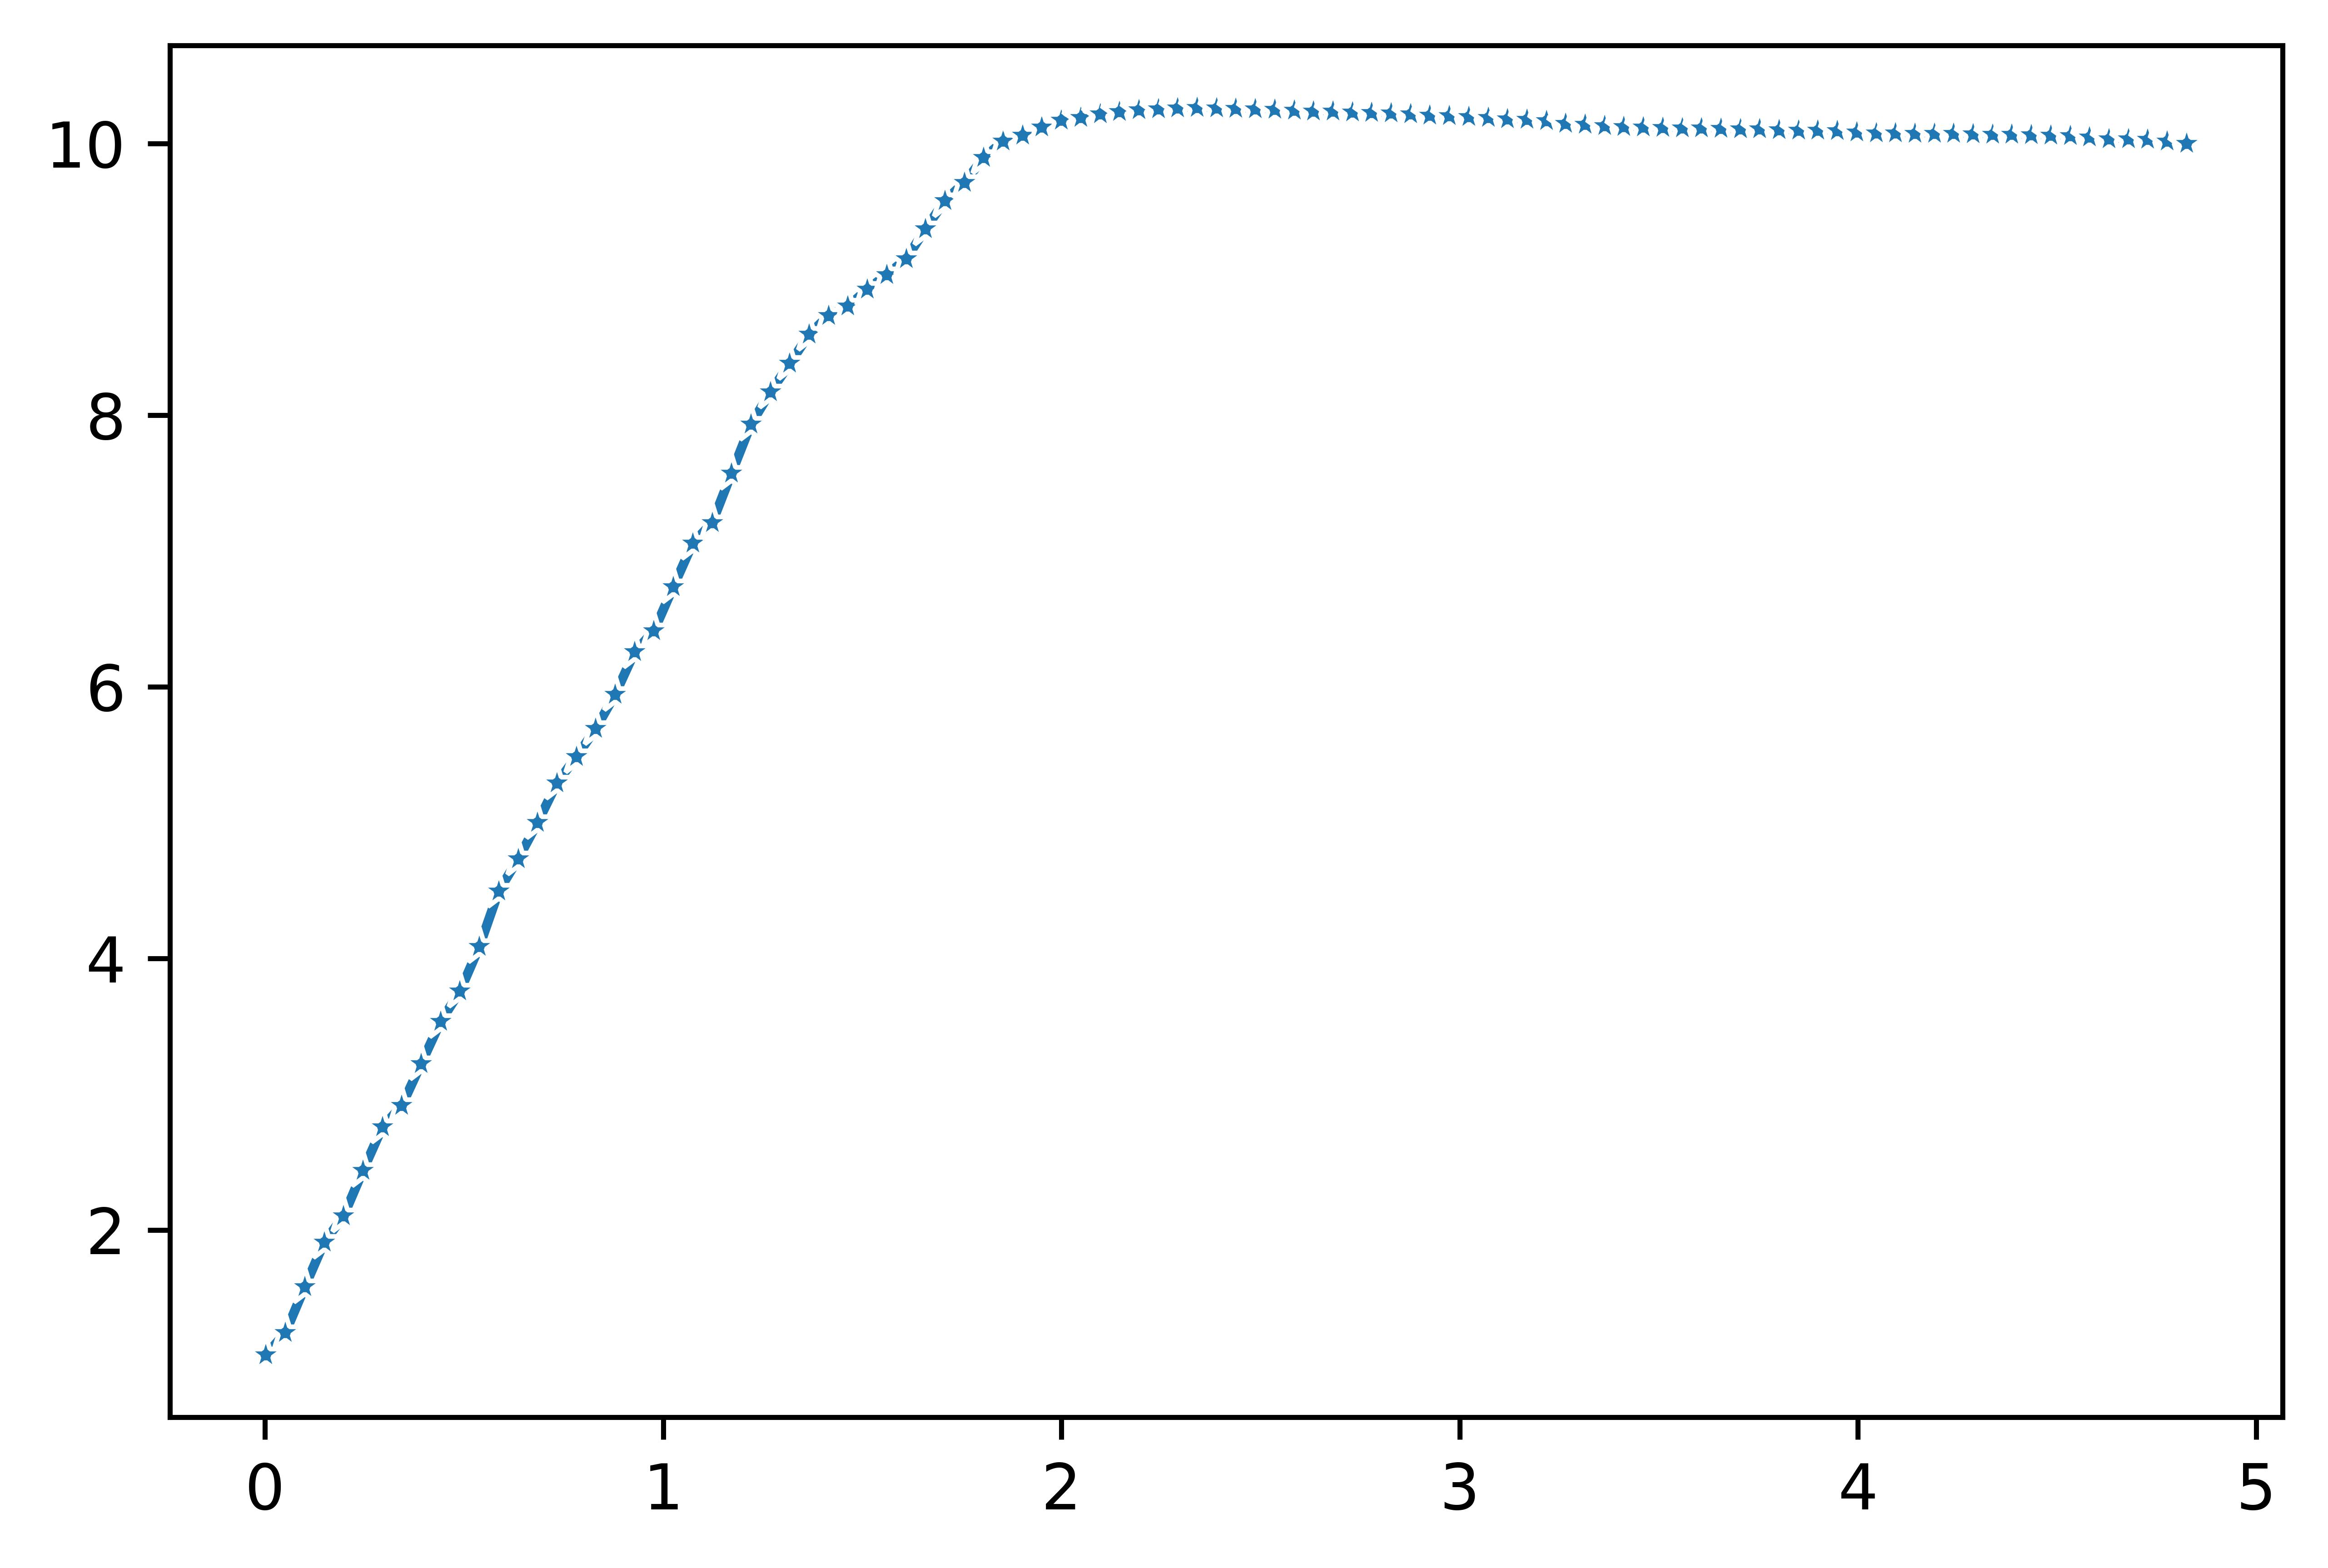

In [19]:
sns.lineplot(x=thresholds[0], y=m_thresh[0], marker='*')

In [20]:
# H_THRESHOLD[0] = min(thresholds[np.argmax(m_thresh)], thresholds[-1])
# H_MODEL = [hsv_skin_model_mean[0], hsv_skin_model_std[0]]

In [21]:
# H_THRESHOLD = min(thresholds[np.argmax(m_thresh)], thresholds[-1])
# H_THRESHOLD

In [22]:
# H_MODEL = [hsv_skin_model_mean[COLOR_CHANNEL_NUM], hsv_skin_model_std[COLOR_CHANNEL_NUM]]
# H_MODEL

In [23]:
# hsv_skin_model_mean[COLOR_CHANNEL_NUM]


In [24]:
# hsv_skin_model_std[COLOR_CHANNEL_NUM]

In [25]:
im = cv2.imread("opencv_frame_0.png")
new_im = im.copy()

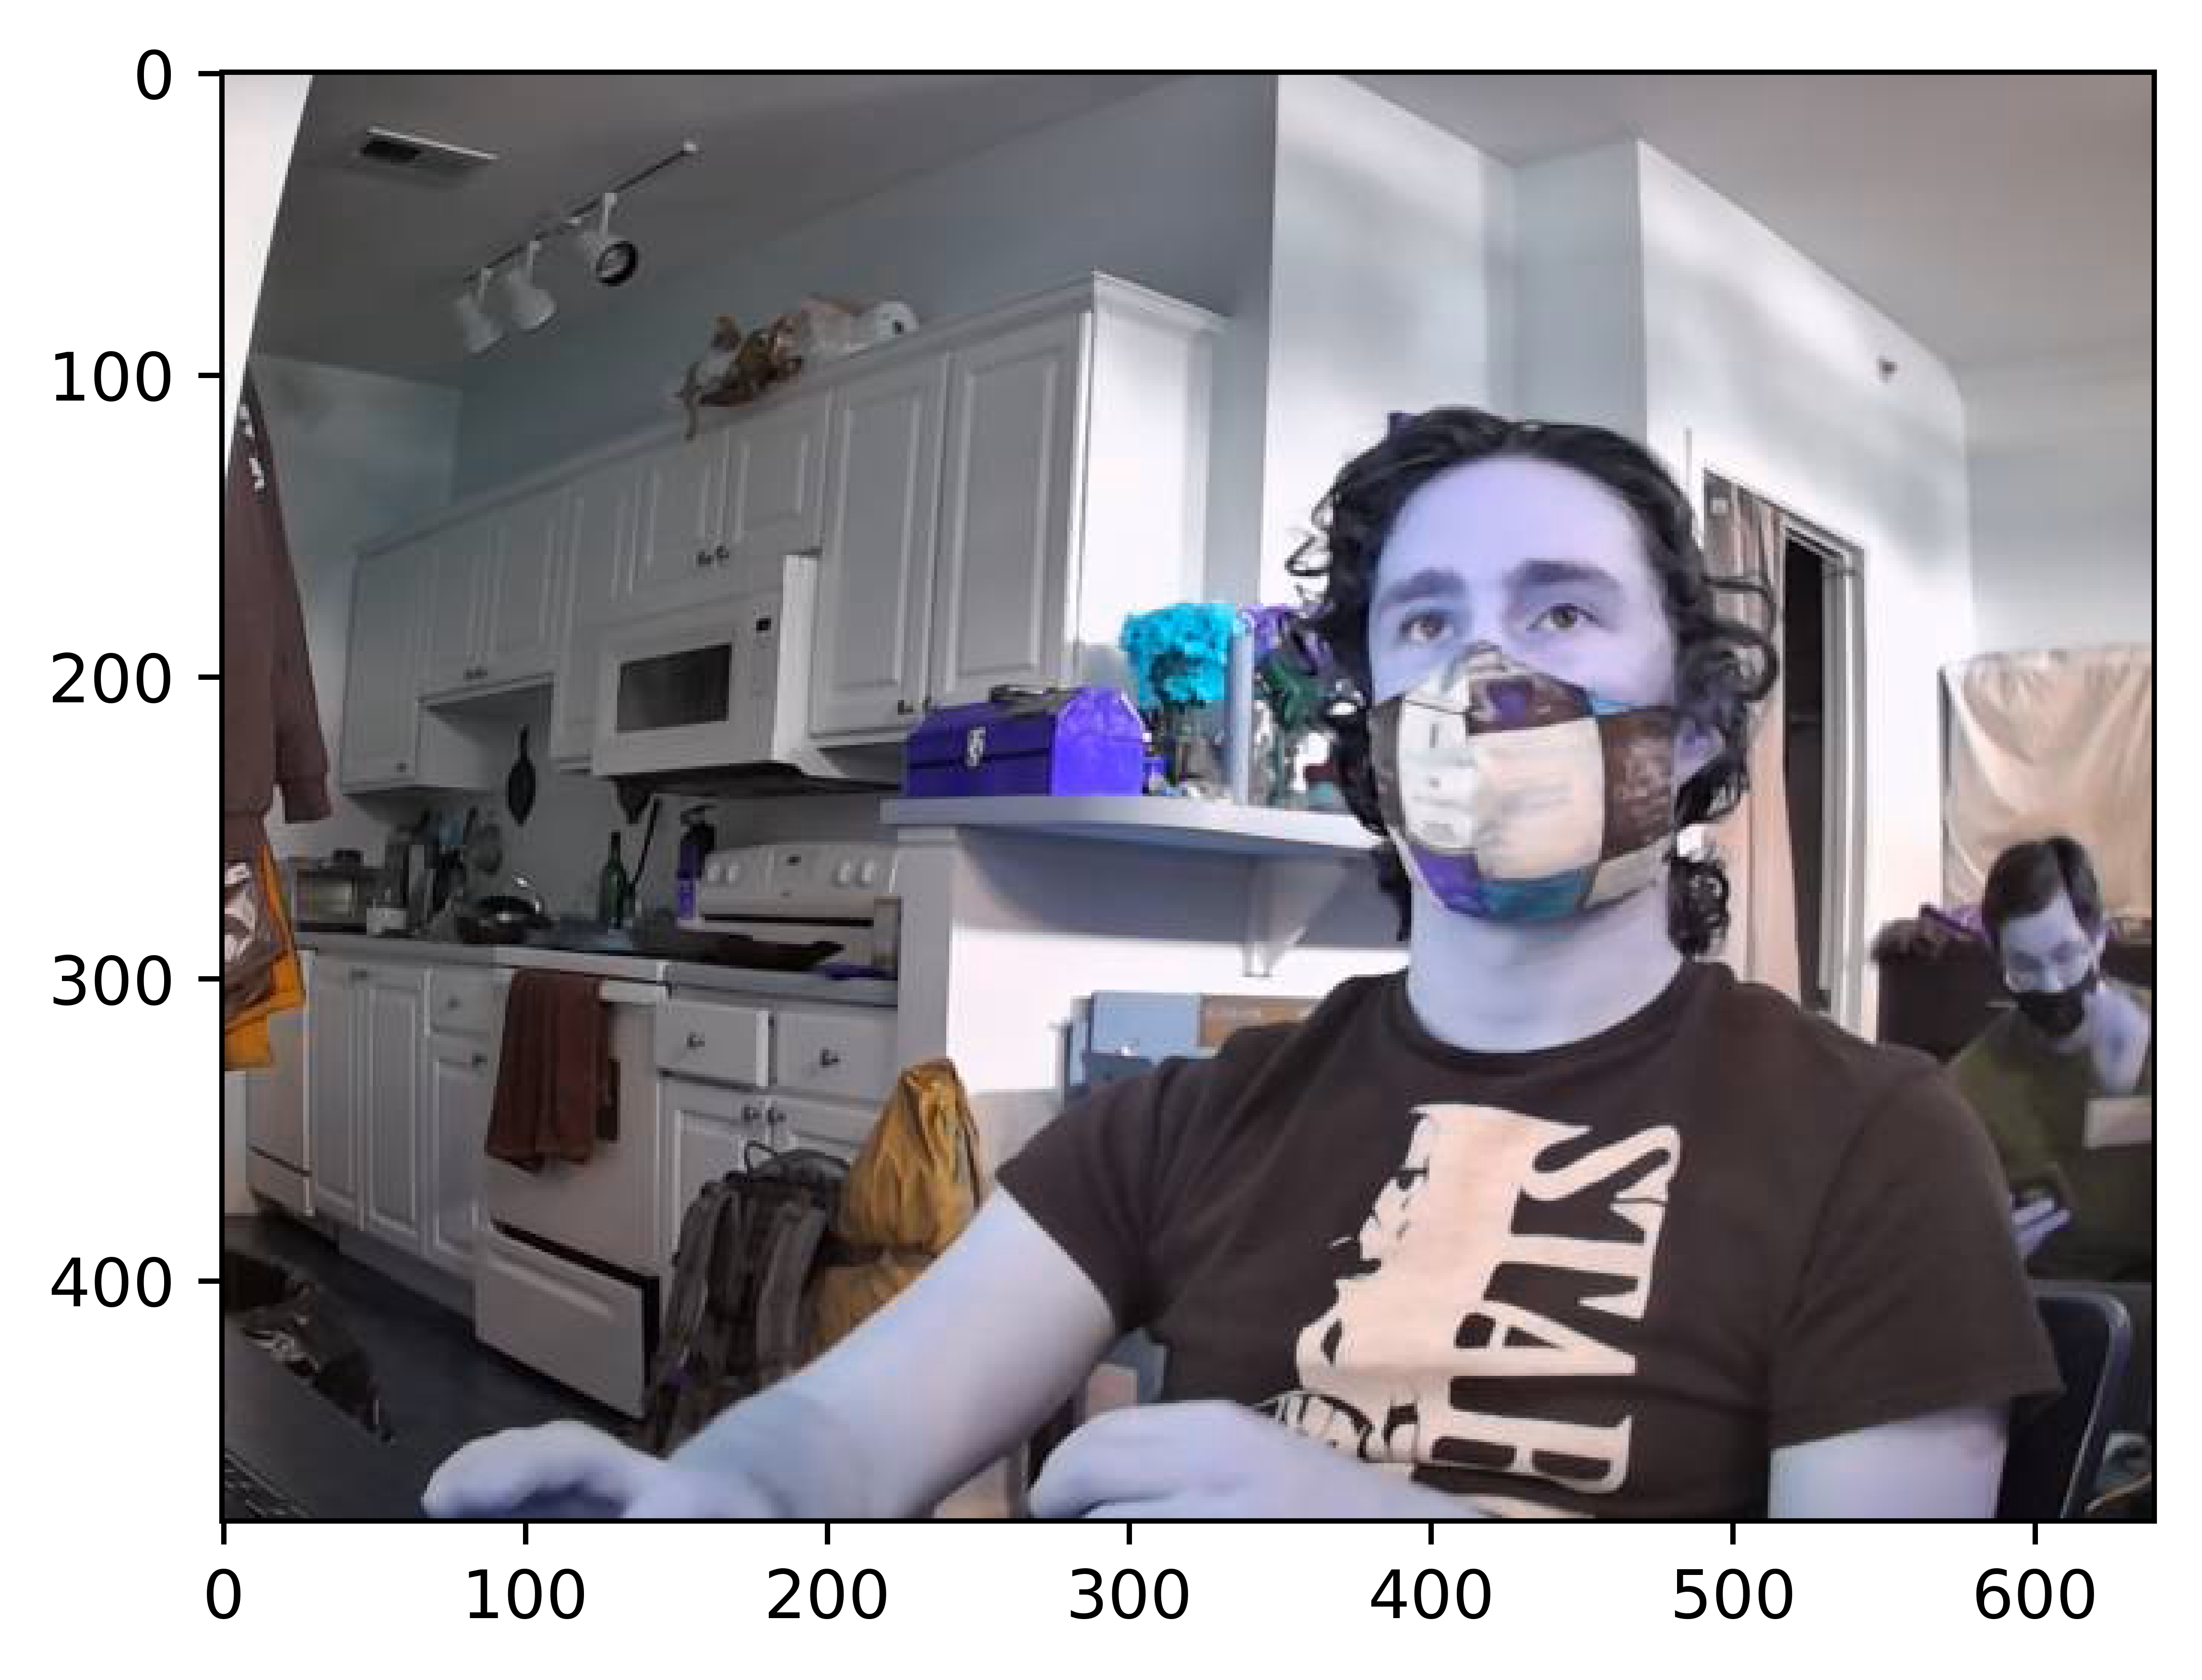

In [26]:
plt.imshow(im)

In [27]:
new_im[...,0] = im[...,2]
new_im[...,1] = im[...,1]
new_im[...,2] = im[...,0]


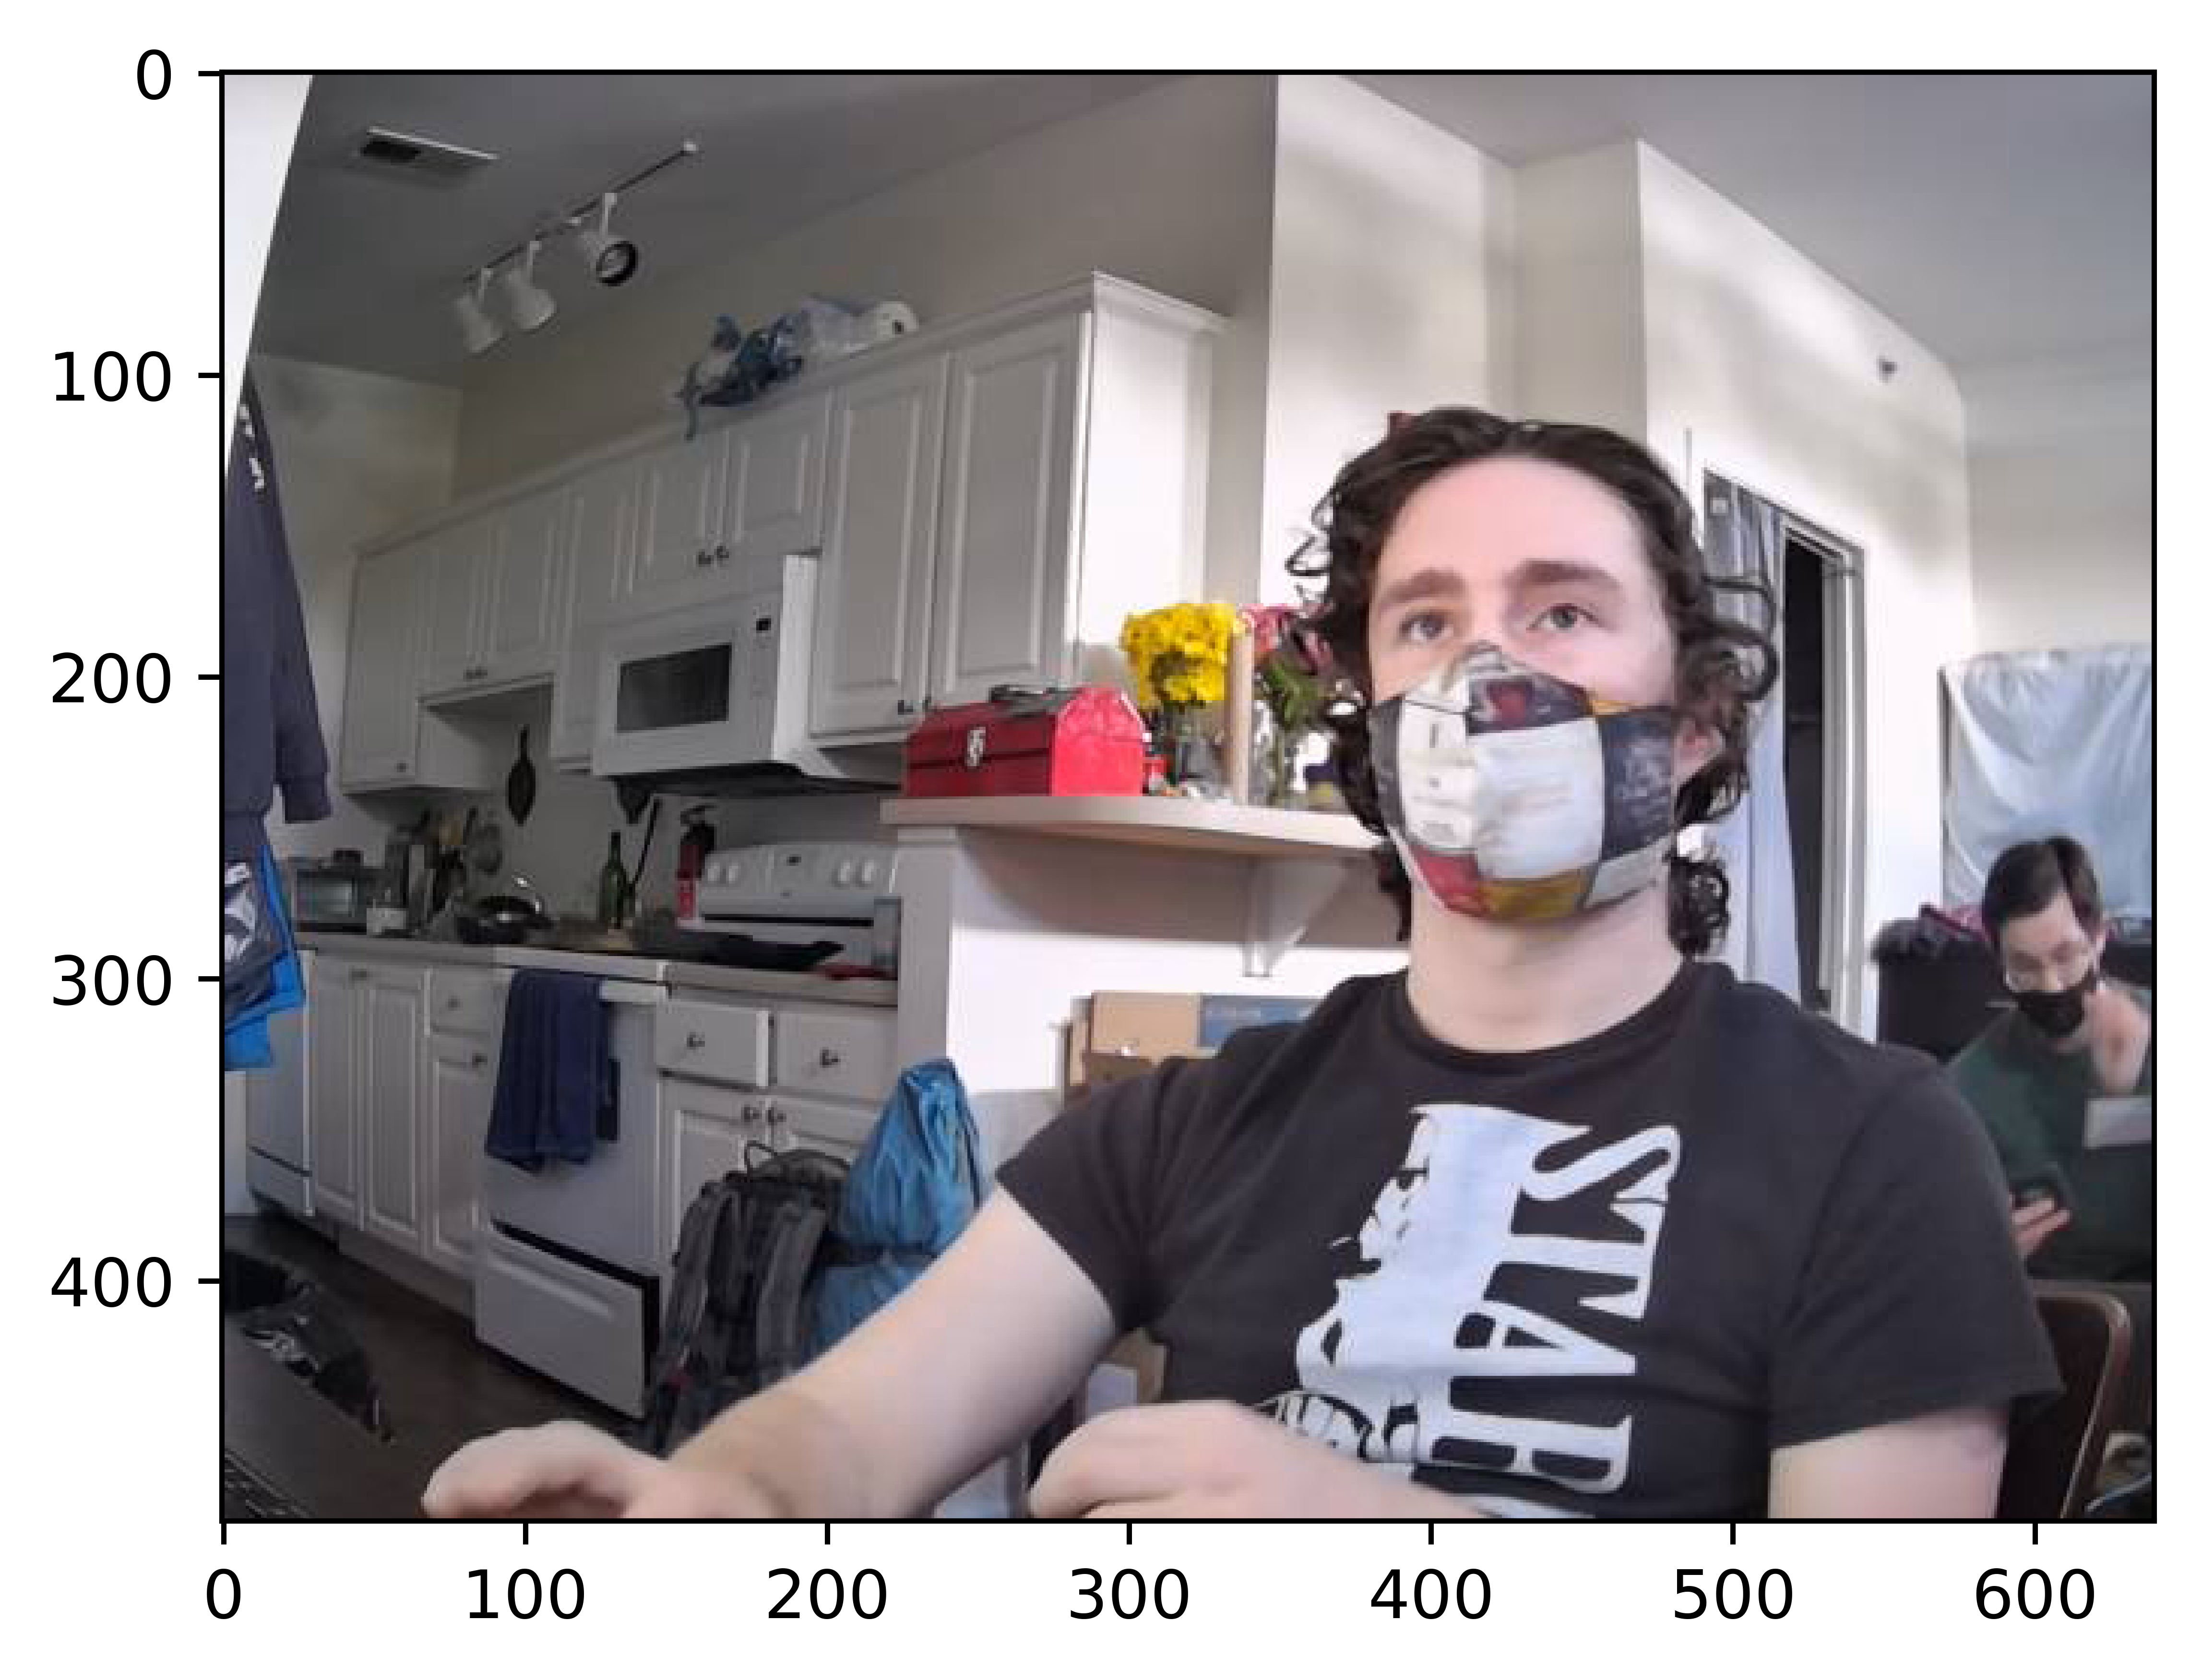

In [28]:
plt.imshow(new_im)

In [29]:
masked_im = [0,0,0]

In [30]:
for color_num in range(3):
    space_im = cv2.cvtColor(np.uint8(im), COLOR_SPACE)
    h_im = space_im[..., color_num]
    h_im_mask = np.reshape(np.abs((h_im - MODEL[color_num][0])/MODEL[color_num][1]) <= THRESHOLD[color_num],
                                  (im.shape[0], im.shape[1], 1))
    masked_im[color_num] = new_im * h_im_mask

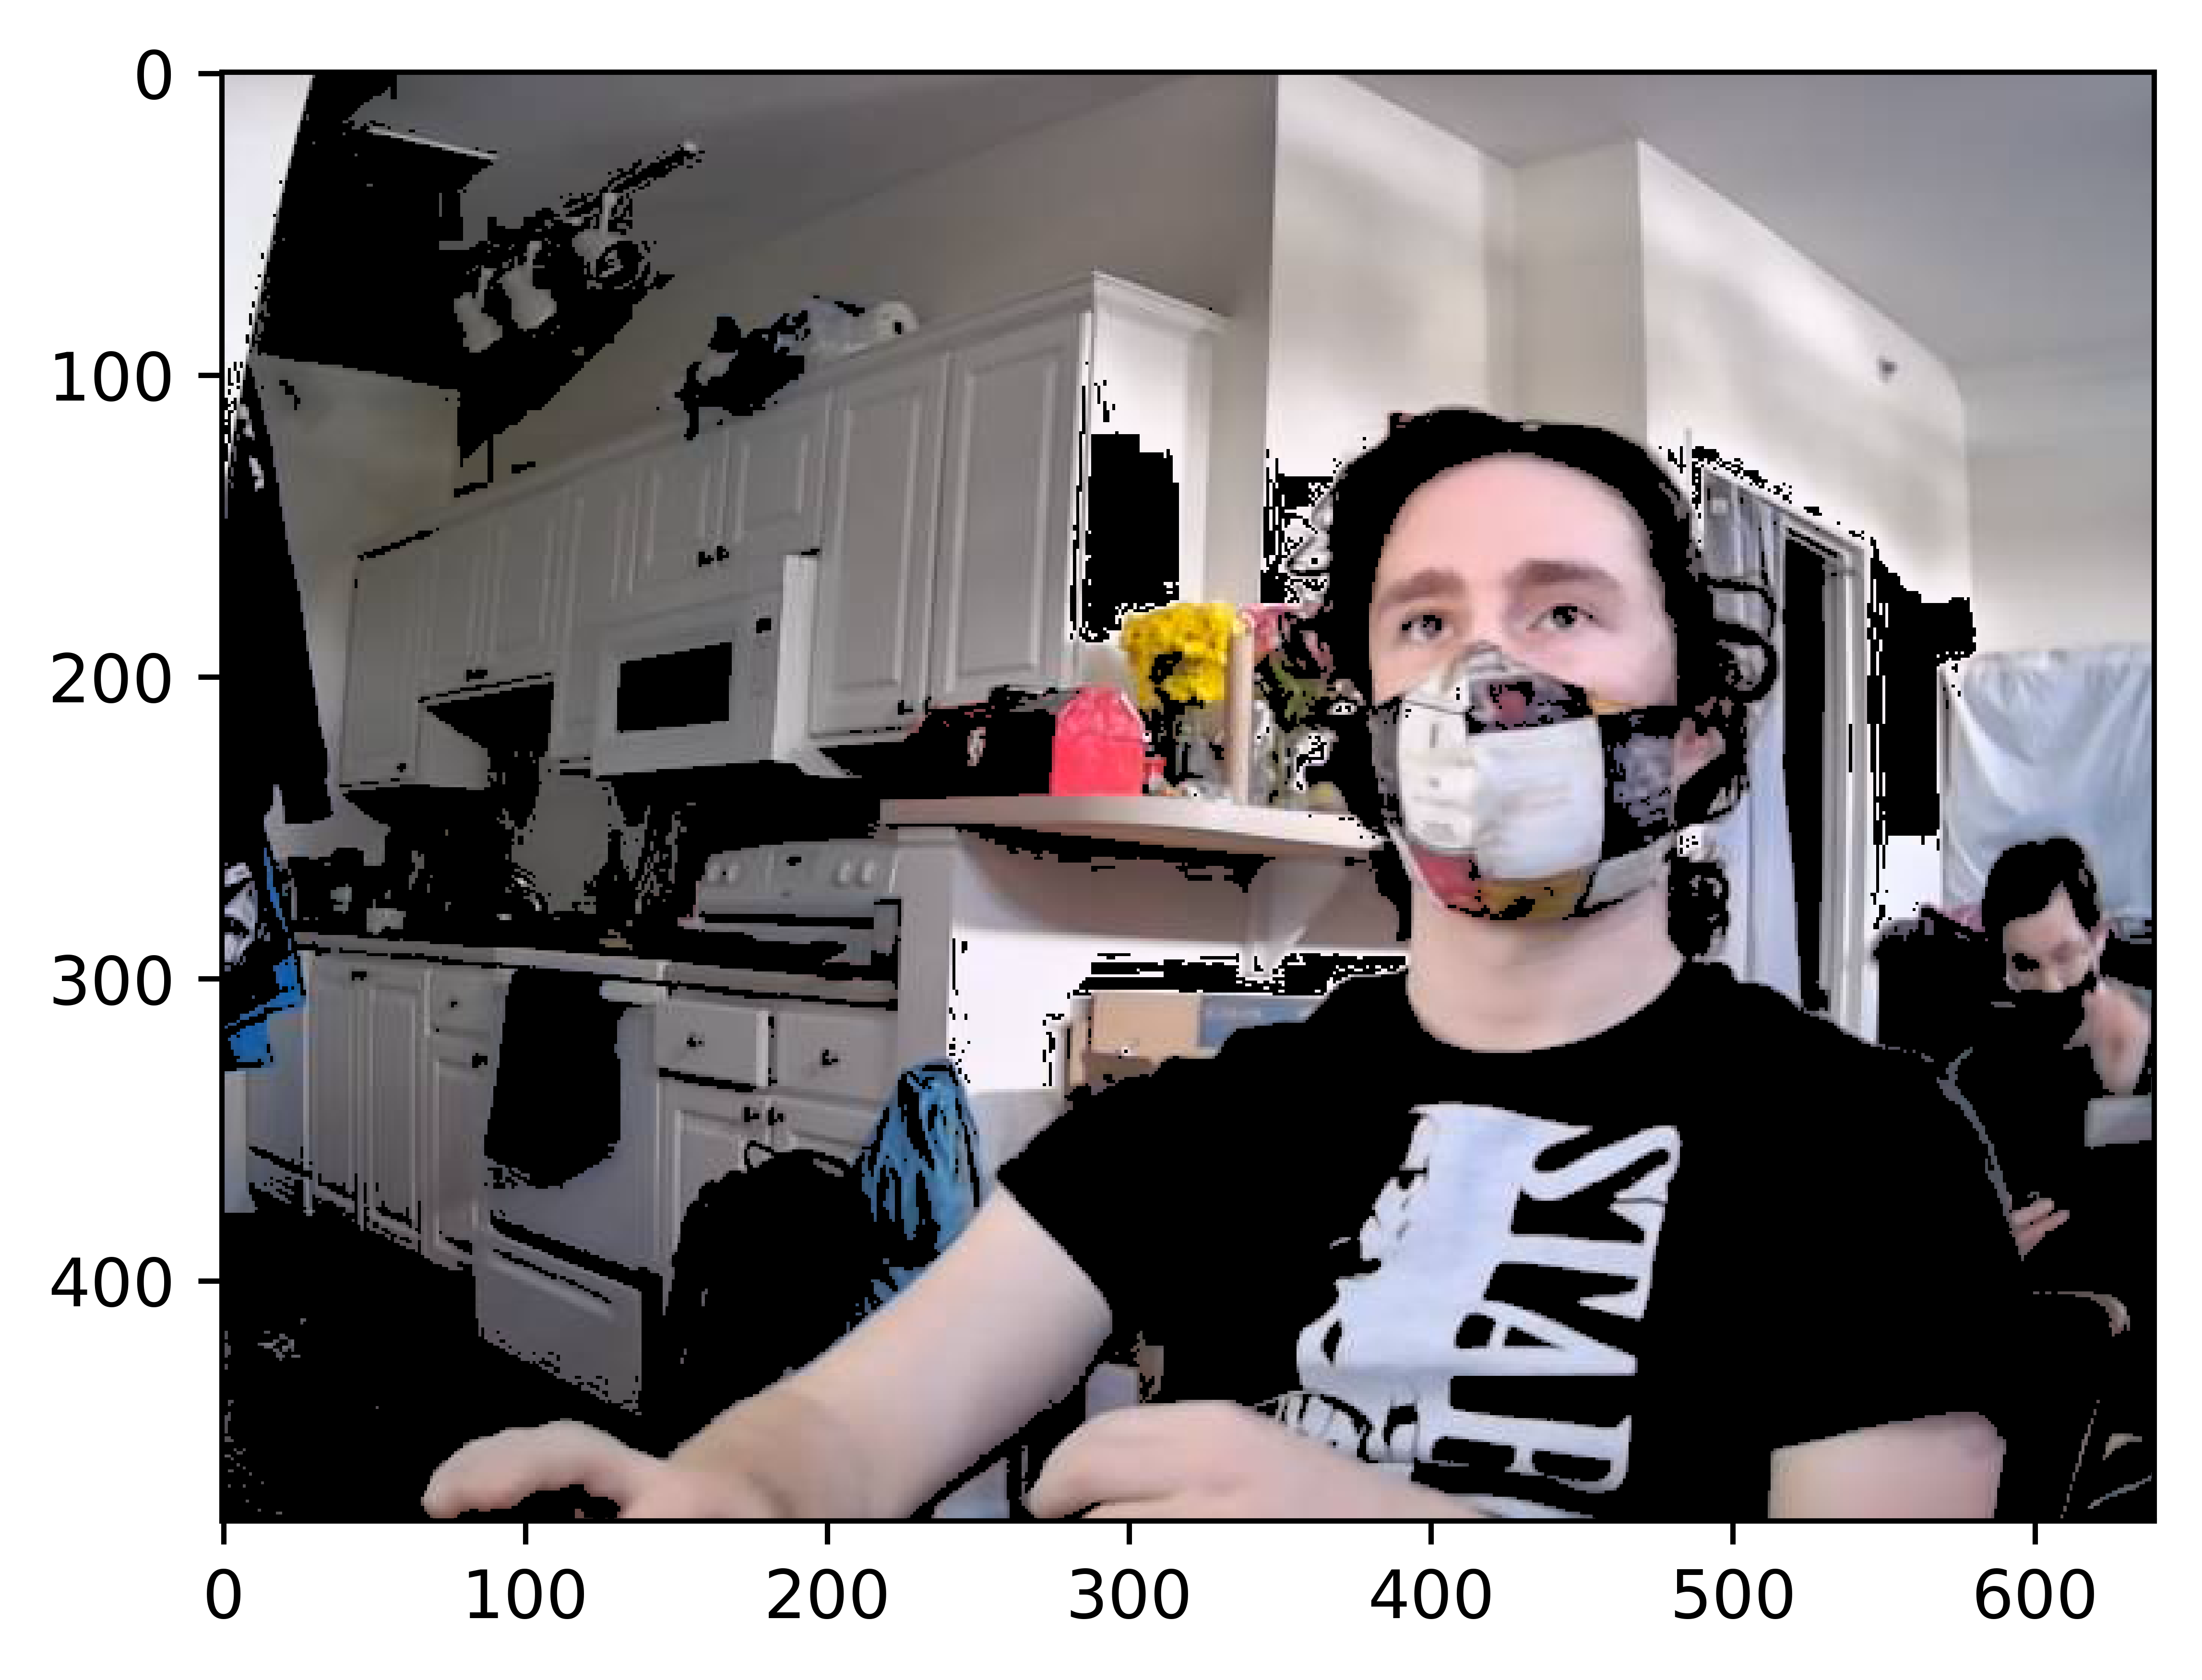

In [31]:
plt.imshow(masked_im[0])

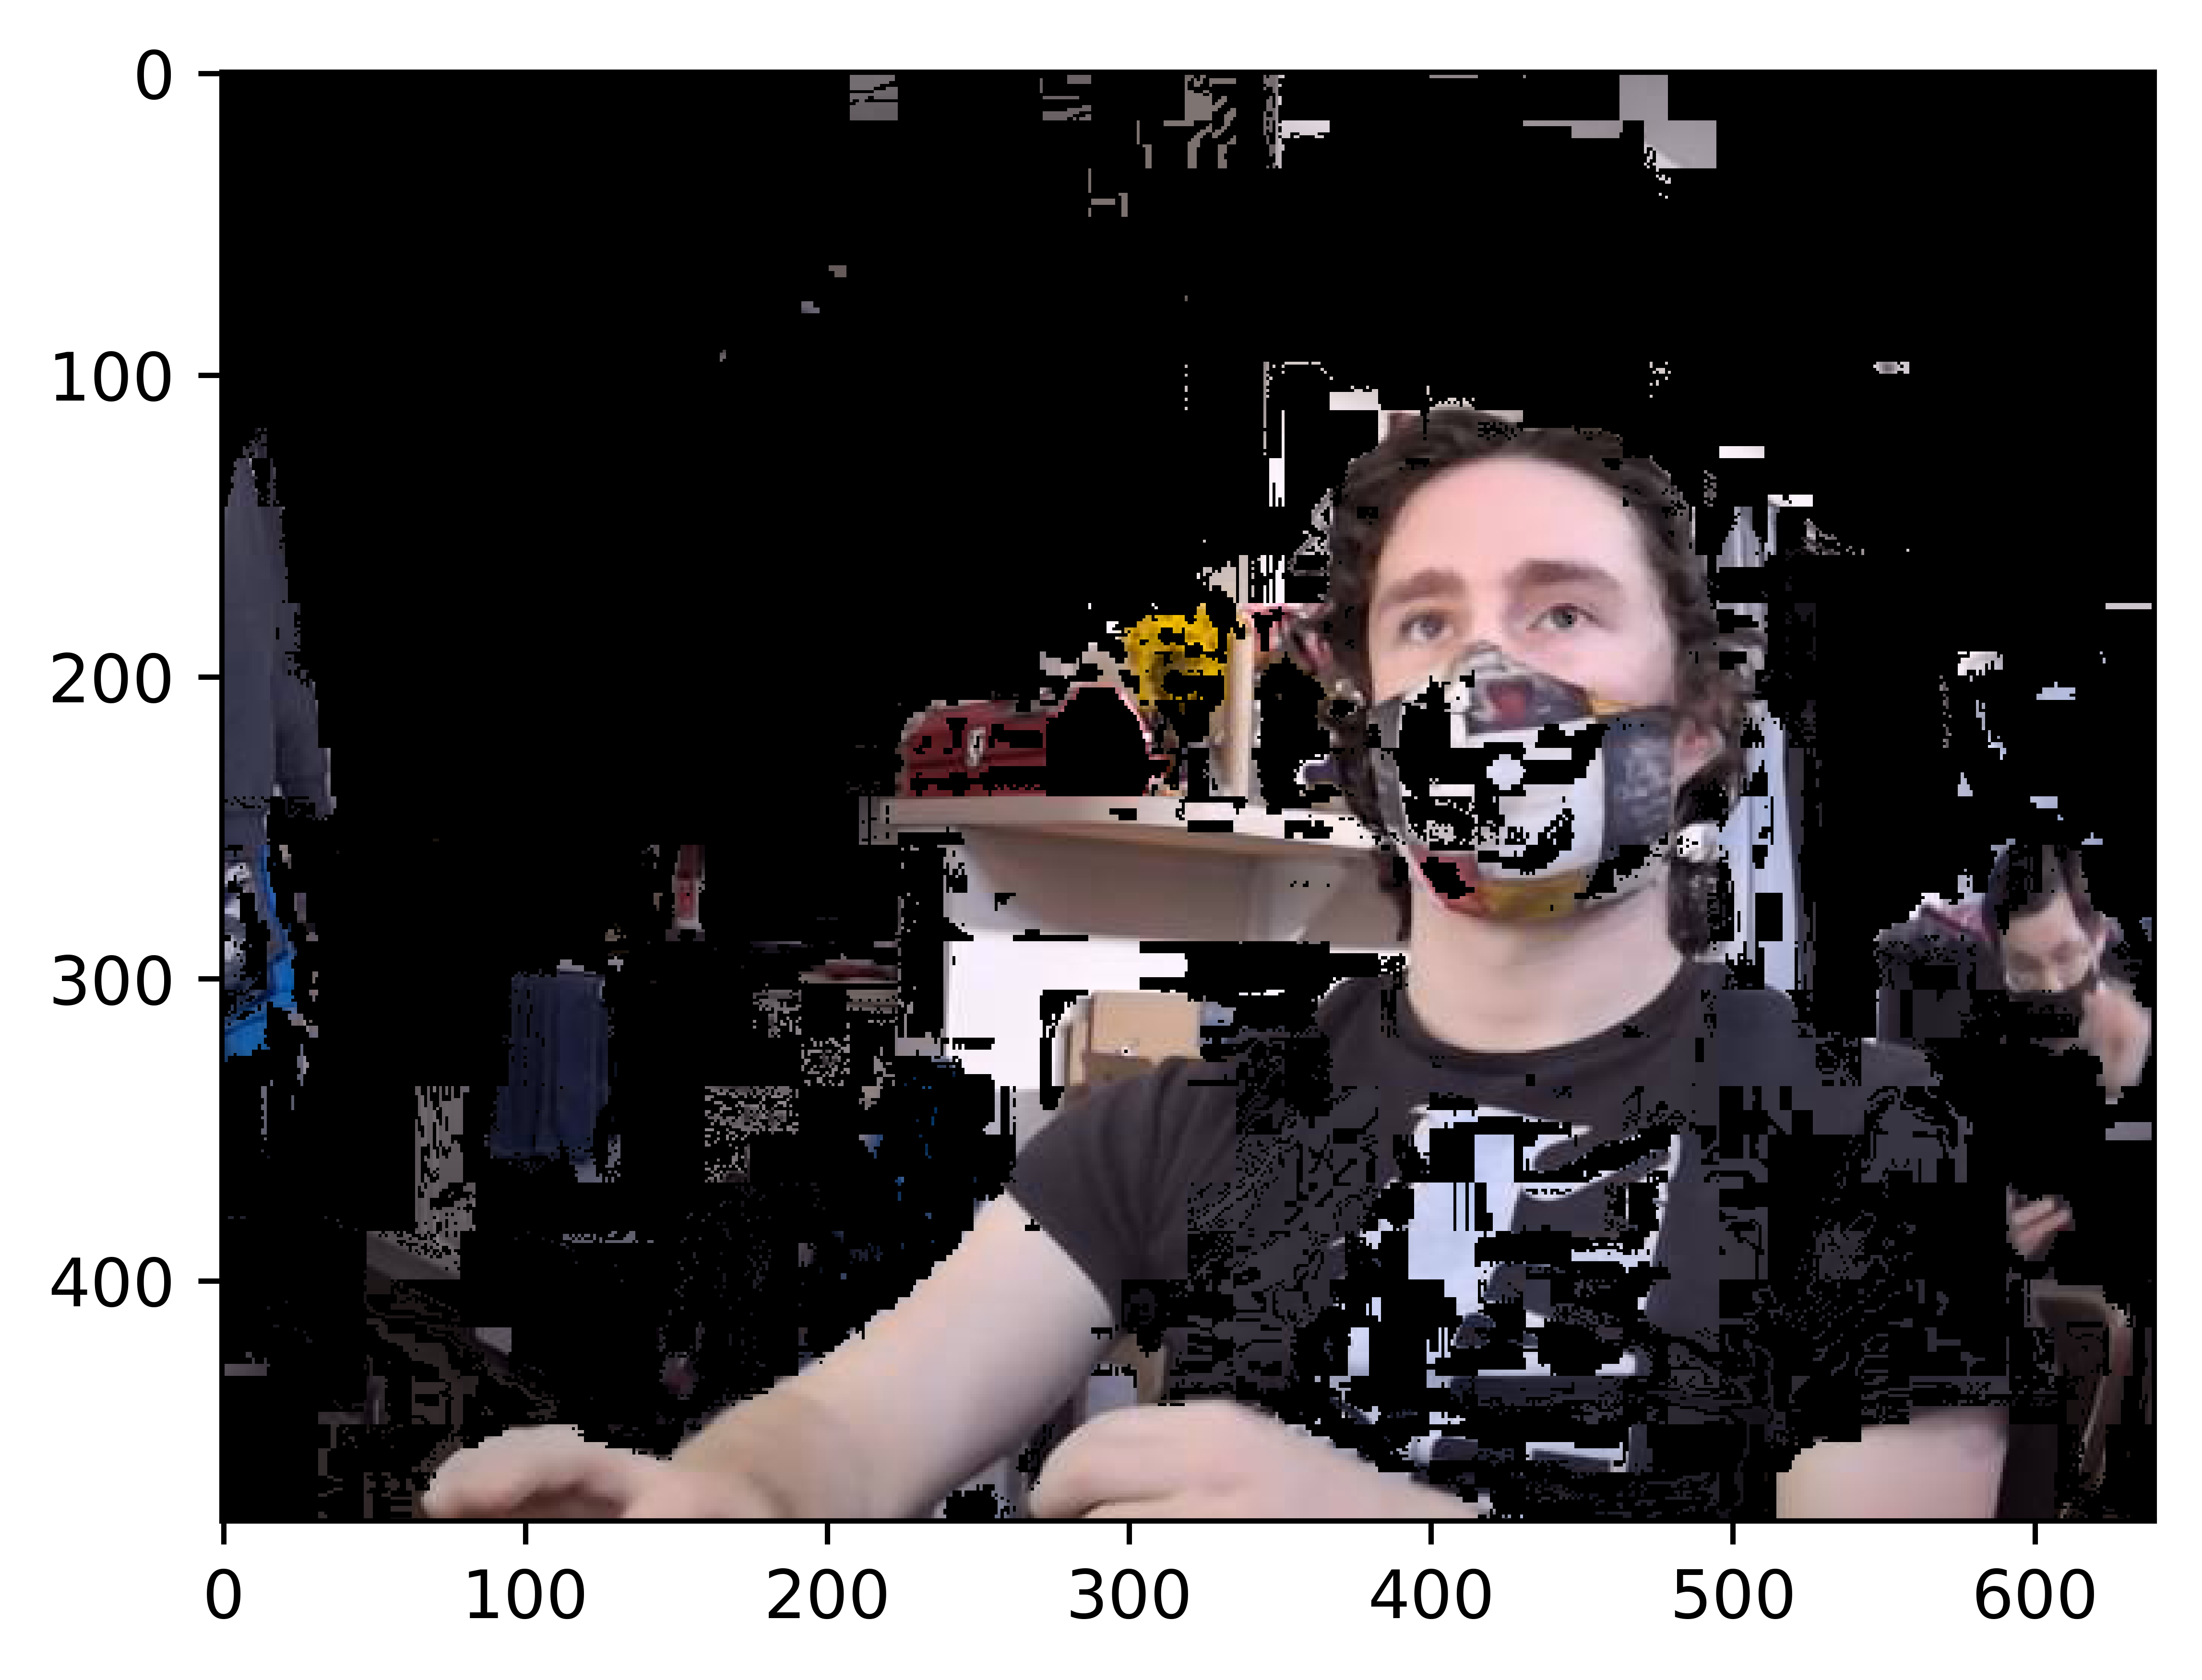

In [32]:
plt.imshow(masked_im[1])

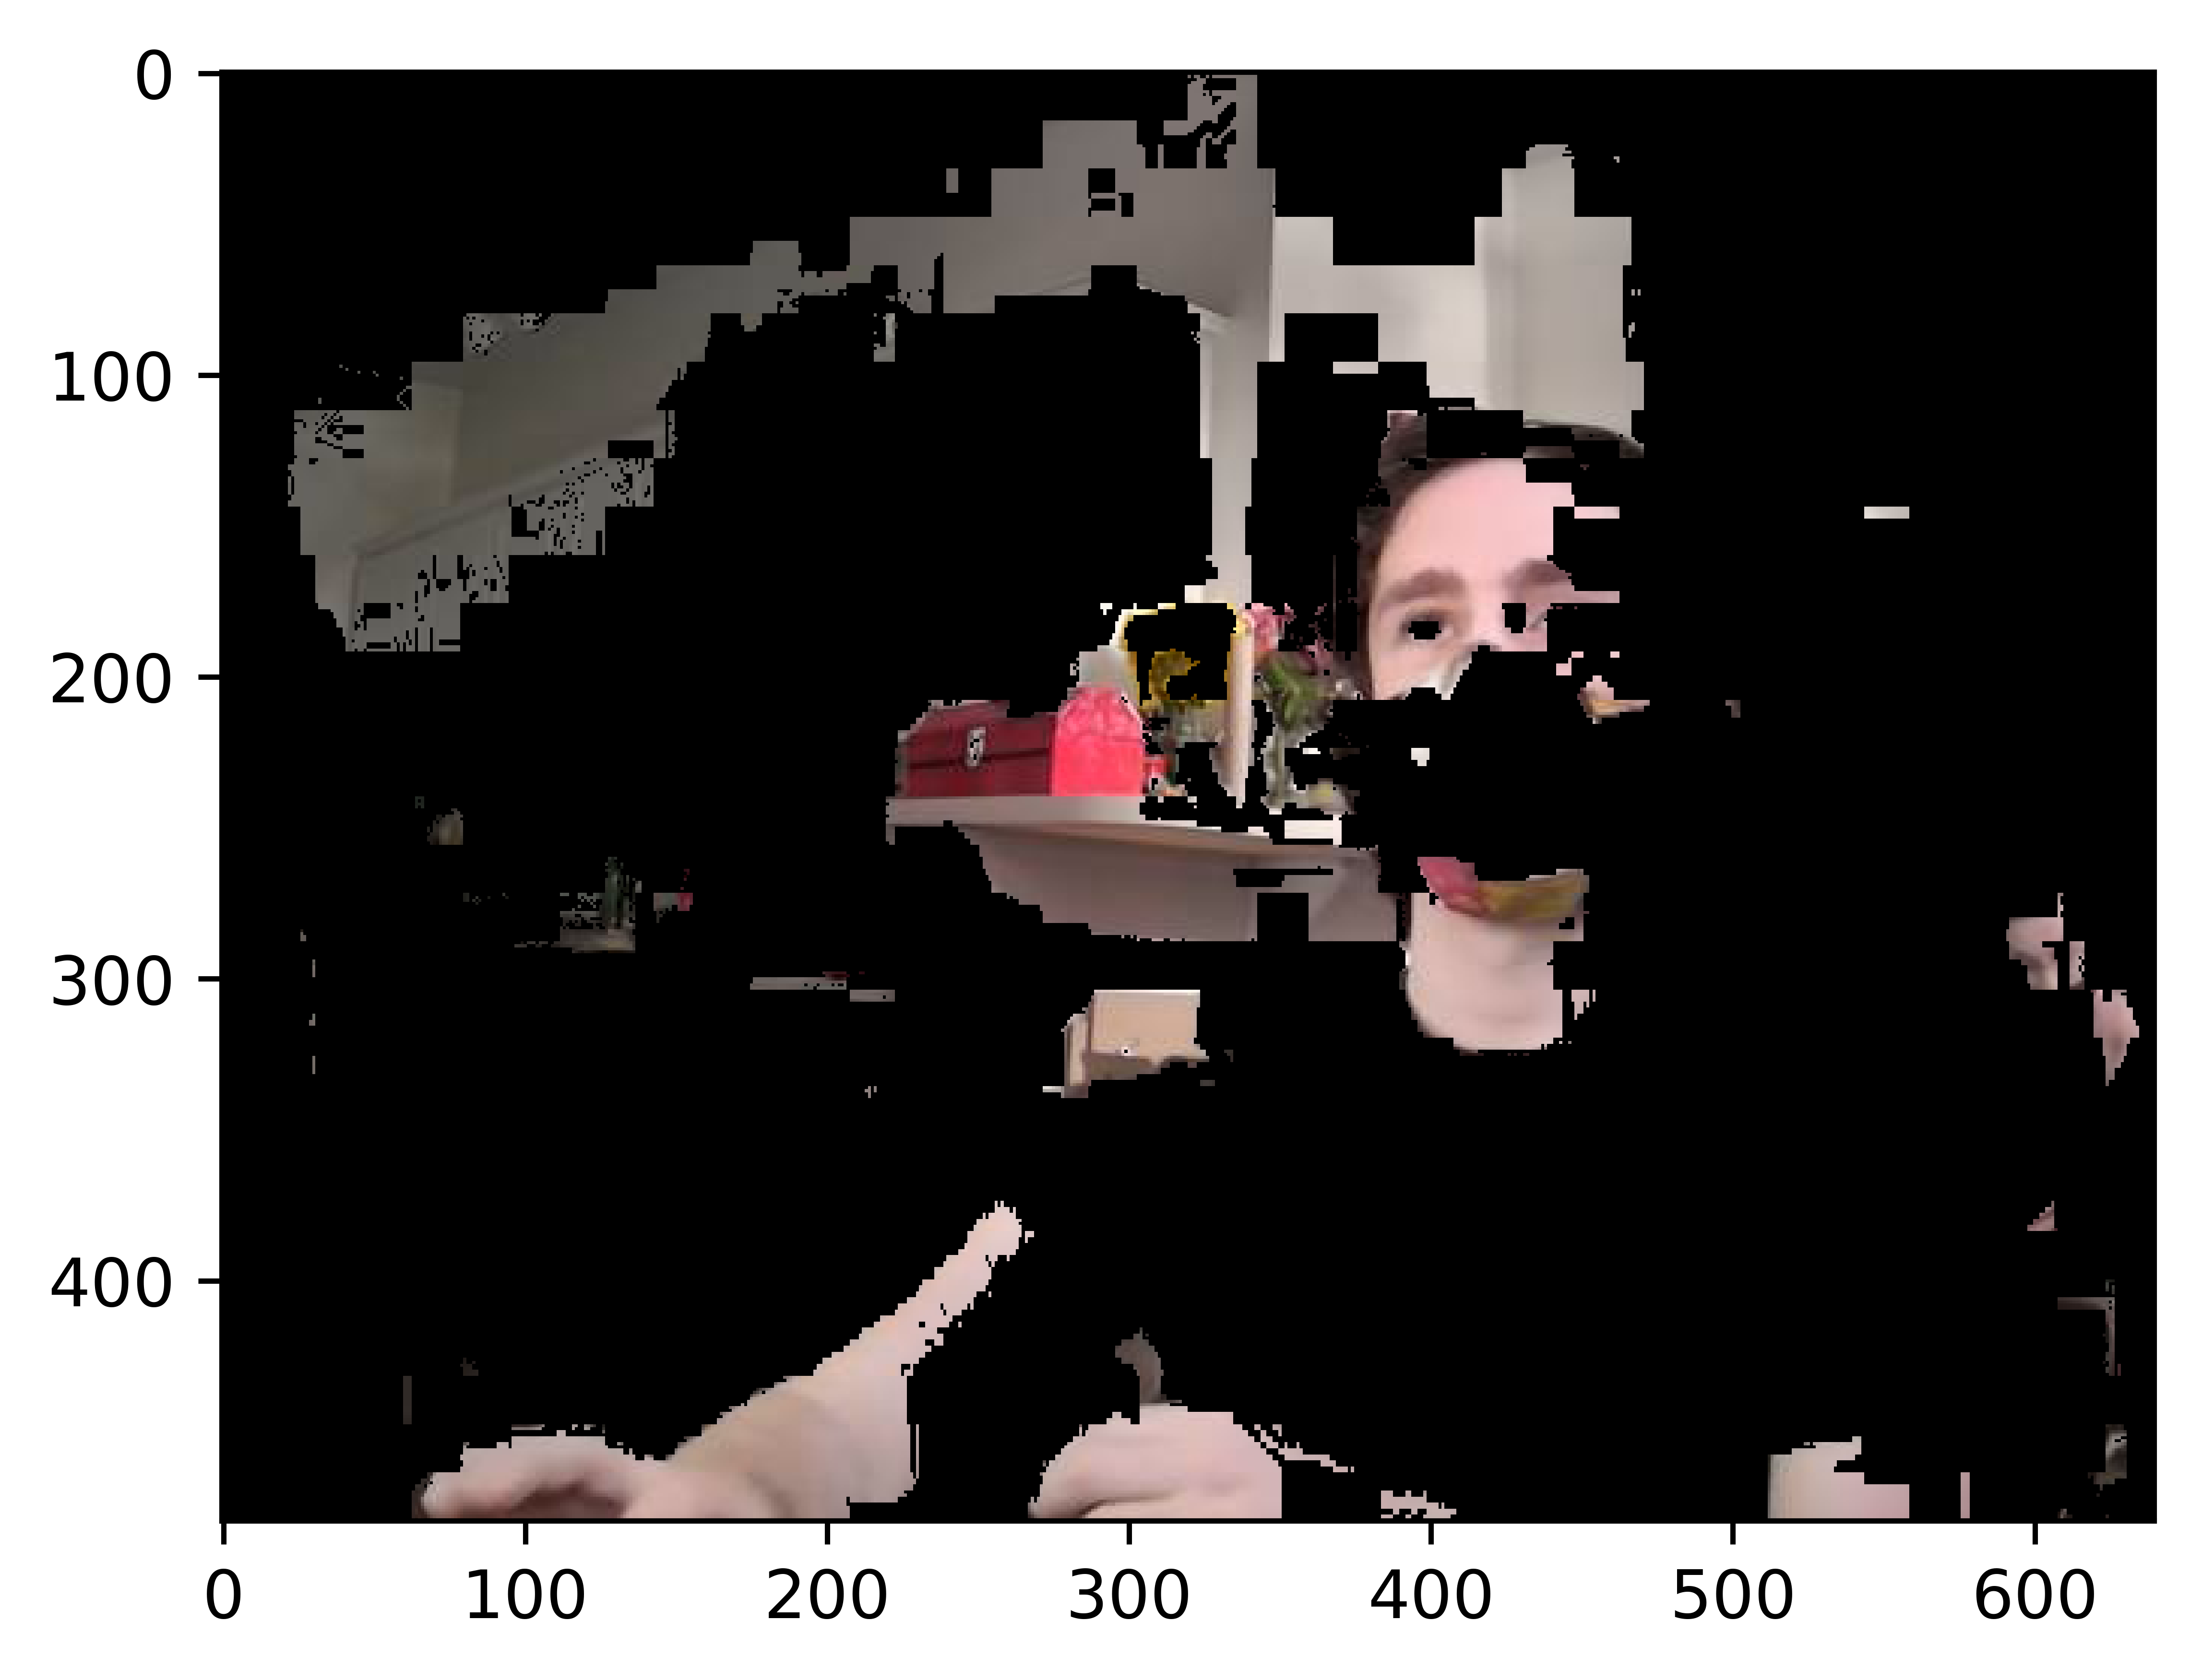

In [33]:
plt.imshow(masked_im[2])

In [34]:
MODEL

[[166.90121709038715, 34.588677506339295],
 [146.01930828368626, 3.8062442597457693],
 [154.02795965315875, 9.633518390359571]]

In [35]:
THRESHOLD

[2.3410172411581796, 3.8690052413348233, 2.3914482466047233]